# Importation and Installation of Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import nltk
import numpy as np
from scrapy.selector import Selector
from selenium import webdriver 
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
print('Set up complete...')

Set up complete...


# Data Scraping

In [56]:

import requests
from bs4 import BeautifulSoup
from time import sleep
from random import randint

HEADERS = {'User-Agent': 'Mozilla/5.0 (iPad; CPU OS 12_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148'}

main = "https://www.imdb.com/search/title/?companies=co0390816"
page = requests.get(main, headers=HEADERS)

sleep(randint(8,15))

soup = BeautifulSoup(page.content, "html.parser")

urls = ["https://www.imdb.com/search/title/?companies=co0390816",    "https://www.imdb.com/search/title/?companies=co0390816&start=51&ref_=adv_nxt"]

published_dates = []
titles = []
links = []
certs = []
genres = []
descriptions = []
ratings = []

for url in urls:
    page = requests.get(url, headers=HEADERS)

    sleep(randint(8, 15))

    soup = BeautifulSoup(page.content, "html.parser")


    movie_container = soup.find_all('div', class_='lister-item mode-advanced')
    
    for container in movie_container:
        published_date = container.find("span", class_="lister-item-year text-muted unbold").text.strip()
        if '(2019)' in published_date or '(2020)' in published_date or '(2021)' in published_date or '(2022)' in published_date:
            published_dates.append(published_date)

            title = container.find("h3", class_="lister-item-header").a.text.strip()
            titles.append(title)

            link = container.find("h3", class_="lister-item-header").a['href']
            links.append(link)

            certificate = container.p.find('span', class_ = 'certificate')
            certs.append(certificate)

            genre = container.p.find('span', class_ = 'genre').text.replace("\n", "").rstrip().split(',')
            genres.append(genre)

            description = container.find("p", class_="text-muted").text.replace('|', '').replace('/n', '').replace(',', '').strip()
            descriptions.append(description)

            rating = container.find("div", class_="ratings-bar").find("strong").text.strip()
            rating_value = round(float(rating), 1)
            ratings.append(rating)

filmlist = pd.DataFrame({'title': titles,
                         'link': ['https://www.imdb.com' + link for link in links],
                         'certificate': certs,
                         'genre': genres,
                         'description': descriptions,
                         'rating': ratings,
                         'published_date': published_dates})

filmlist['review_link'] = filmlist['link'].apply(lambda x: x + 'reviews')
filmlist['published_date'] = filmlist['published_date'].apply(lambda x: x.replace('(I)', '').replace('(II)', ''))
filmlist['description'] = filmlist['description'].apply(lambda x: x.replace('\n', ''))


filmlist.to_csv('filmlist.csv', index=False)

'\n\nHEADERS = {\'User-Agent\': \'Mozilla/5.0 (iPad; CPU OS 12_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148\'}\n\nmain = "https://www.imdb.com/search/title/?companies=co0390816"\npage = requests.get(main, headers=HEADERS)\n\nsleep(randint(8,15))\n\nsoup = BeautifulSoup(page.content, "html.parser")\n\nHEADERS = {\n    \'User-Agent\': \'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3\'}\n\nurls = ["https://www.imdb.com/search/title/?companies=co0390816",    "https://www.imdb.com/search/title/?companies=co0390816&start=51&ref_=adv_nxt"]\n\npublished_dates = []\ntitles = []\nlinks = []\ncerts = []\ngenres = []\ndescriptions = []\nratings = []\n\nfor url in urls:\n    page = requests.get(url, headers=HEADERS)\n\n    sleep(randint(8, 15))\n\n    soup = BeautifulSoup(page.content, "html.parser")\n\n\n    movie_container = soup.find_all(\'div\', class_=\'lister-item mode-advanced\')\n    \n    for con

In [2]:
fl = pd.read_csv('filmlist.csv')
fl['review_link'] = fl['review_link'].apply(lambda x: x.replace('?ref_=adv_li_tt', ''))
fl.head()

FileNotFoundError: [Errno 2] No such file or directory: 'filmlist.csv'

In [65]:
data = pd.DataFrame(columns=['review_date', 'author', 'rating', 'review_title', 'review', 'review_url', 'film_title'])

for url in fl['review_link']:
    page = requests.get(url)

    soup = BeautifulSoup(page.content, "html.parser")

    film_title = soup.title.string.split(' - ')[0]

    review_titles = soup.find_all('a', class_='title')

    #//

    driver = webdriver.Chrome('chromedriver.exe')
    time.sleep(1)
    driver.get(url)
    time.sleep(1)
    print(driver.title)
    time.sleep(1)
    body = driver.find_element(By.CSS_SELECTOR, 'body')
    body.send_keys(Keys.PAGE_DOWN)
    time.sleep(1)
    body.send_keys(Keys.PAGE_DOWN)
    time.sleep(1)
    body.send_keys(Keys.PAGE_DOWN)

    #//

    sel = Selector(text = driver.page_source)
    review_counts = sel.css('.lister .header span::text').extract_first().replace(',','').split(' ')[0]
    more_review_pages = int(int(review_counts)/25)

    #//

    for i in tqdm(range(more_review_pages)):
        try:
            css_selector = 'load-more-trigger'
            driver.find_element(By.ID, css_selector).click()
        except:
            pass

    #//

    rating_list = []
    review_date_list = []
    review_title_list = []
    author_list = []
    review_list = []
    review_url_list = []
    error_url_list = []
    error_msg_list = []
    reviews = driver.find_elements(By.CSS_SELECTOR, 'div.review-container')

    for d in tqdm(reviews):
        try:
            sel2 = Selector(text = d.get_attribute('innerHTML'))
            try:
                rating = sel2.css('.rating-other-user-rating span::text').extract_first()
            except:
                rating = np.NaN
            try:
                review = sel2.css('.text.show-more__control::text').extract_first()
            except:
                review = np.NaN
            try:
                review_date = sel2.css('.review-date::text').extract_first()
            except:
                review_date = np.NaN    
            try:
                author = sel2.css('.display-name-link a::text').extract_first()
            except:
                author = np.NaN    
            try:
                review_title = sel2.css('a.title::text').extract_first()
            except:
                review_title = np.NaN
            try:
                review_url = sel2.css('a.title::attr(href)').extract_first()
            except:
                review_url = np.NaN


            rating_list.append(rating)
            review_date_list.append(review_date)
            review_title_list.append(review_title)
            author_list.append(author)
            review_list.append(review)
            review_url_list.append(review_url)
            film_title.append(film_title)
        except Exception as e:
            error_url_list.append(url)
            error_msg_list.append(e)

    reviews = pd.DataFrame({
        'review_date':review_date_list,
        'author':author_list,
        'rating':rating_list,
        'review_title':review_title_list,
        'review':review_list,
        'review_url':review_url,
        'film_title':(film_title)
        })

    data = data.append(reviews, ignore_index=True)
    data.to_csv('data.csv', index=False)

Everything Everywhere All at Once (2022) - Everything Everywhere All at Once (2022) - User Reviews - IMDb


100%|██████████| 275/275 [00:08<00:00, 33.57it/s]


The Whale (2022) - The Whale (2022) - User Reviews - IMDb


100%|██████████| 50/50 [00:01<00:00, 35.62it/s]


X (2022) - X (2022) - User Reviews - IMDb


100%|██████████| 75/75 [00:02<00:00, 33.27it/s]


Midsommar (2019) - Midsommar (2019) - User Reviews - IMDb


100%|██████████| 175/175 [00:04<00:00, 38.27it/s]


Aftersun (2022) - Aftersun (2022) - User Reviews - IMDb


100%|██████████| 25/25 [00:00<00:00, 25.82it/s]


Pearl (2022) - Pearl (2022) - User Reviews - IMDb


100%|██████████| 25/25 [00:00<00:00, 28.78it/s]


Bodies Bodies Bodies (2022) - Bodies Bodies Bodies (2022) - User Reviews - IMDb


100%|██████████| 50/50 [00:01<00:00, 33.10it/s]


Close (2022) - Close (2022) - User Reviews - IMDb


100%|██████████| 25/25 [00:01<00:00, 15.01it/s]


Uncut Gems (2019) - Uncut Gems (2019) - User Reviews - IMDb


100%|██████████| 100/100 [00:02<00:00, 42.58it/s]


White Noise (2022) - White Noise (2022) - User Reviews - IMDb


100%|██████████| 25/25 [00:01<00:00, 24.59it/s]


The Green Knight (2021) - The Green Knight (2021) - User Reviews - IMDb


100%|██████████| 100/100 [00:02<00:00, 46.04it/s]


Men (2022) - Men (2022) - User Reviews - IMDb


100%|██████████| 50/50 [00:01<00:00, 30.37it/s]


Showing Up (2022) - Showing Up (2022) - User Reviews - IMDb


0it [00:00, ?it/s]
0it [00:00, ?it/s]


The Lighthouse (2019) - The Lighthouse (2019) - User Reviews - IMDb


100%|██████████| 125/125 [00:03<00:00, 41.39it/s]


Marcel the Shell with Shoes On (2021) - Marcel the Shell with Shoes On (2021) - User Reviews - IMDb


100%|██████████| 25/25 [00:01<00:00, 22.68it/s]


Causeway (2022) - Causeway (2022) - User Reviews - IMDb


100%|██████████| 25/25 [00:00<00:00, 26.75it/s]


God's Creatures (2022) - God's Creatures (2022) - User Reviews - IMDb


100%|██████████| 25/25 [00:00<00:00, 38.56it/s]


Minari (2020) - Minari (2020) - User Reviews - IMDb


100%|██████████| 25/25 [00:01<00:00, 23.13it/s]


The Tragedy of Macbeth (2021) - The Tragedy of Macbeth (2021) - User Reviews - IMDb


100%|██████████| 25/25 [00:01<00:00, 19.55it/s]


Red Rocket (2021) - Red Rocket (2021) - User Reviews - IMDb


100%|██████████| 25/25 [00:01<00:00, 21.49it/s]


Irma Vep (TV Series 2022) - Irma Vep (TV Series 2022) - User Reviews - IMDb


100%|██████████| 25/25 [00:01<00:00, 17.47it/s]


Lamb (2021) - Lamb (2021) - User Reviews - IMDb


100%|██████████| 50/50 [00:01<00:00, 36.14it/s]


Talk to Me (2022) - Talk to Me (2022) - User Reviews - IMDb


0it [00:00, ?it/s]
100%|██████████| 6/6 [00:00<00:00, 21.88it/s]


Waves (2019) - Waves (2019) - User Reviews - IMDb


100%|██████████| 25/25 [00:00<00:00, 28.21it/s]


After Yang (2021) - After Yang (2021) - User Reviews - IMDb


100%|██████████| 25/25 [00:01<00:00, 21.70it/s]


Saint Maud (2019) - Saint Maud (2019) - User Reviews - IMDb


100%|██████████| 25/25 [00:01<00:00, 22.37it/s]


C'mon C'mon (2021) - C'mon C'mon (2021) - User Reviews - IMDb


100%|██████████| 25/25 [00:01<00:00, 23.27it/s]


Zola (2020) - Zola (2020) - User Reviews - IMDb


100%|██████████| 25/25 [00:01<00:00, 24.94it/s]


The Inspection (2022) - The Inspection (2022) - User Reviews - IMDb


0it [00:00, ?it/s]
100%|██████████| 15/15 [00:00<00:00, 35.23it/s]


Stars at Noon (2022) - Stars at Noon (2022) - User Reviews - IMDb


0it [00:00, ?it/s]
100%|██████████| 21/21 [00:00<00:00, 37.74it/s]


The Death of Dick Long (2019) - The Death of Dick Long (2019) - User Reviews - IMDb


100%|██████████| 25/25 [00:01<00:00, 23.62it/s]


The Eternal Daughter (2022) - The Eternal Daughter (2022) - User Reviews - IMDb


100%|██████████| 25/25 [00:00<00:00, 30.97it/s]


When You Finish Saving the World (2022) - When You Finish Saving the World (2022) - User Reviews - IMDb


0it [00:00, ?it/s]
100%|██████████| 24/24 [00:00<00:00, 38.48it/s]


First Cow (2019) - First Cow (2019) - User Reviews - IMDb


100%|██████████| 25/25 [00:00<00:00, 27.86it/s]


The Last Black Man in San Francisco (2019) - The Last Black Man in San Francisco (2019) - User Reviews - IMDb


100%|██████████| 25/25 [00:01<00:00, 22.19it/s]


The Hole in the Ground (2019) - The Hole in the Ground (2019) - User Reviews - IMDb


100%|██████████| 25/25 [00:01<00:00, 24.84it/s]


The Farewell (2019) - The Farewell (2019) - User Reviews - IMDb


100%|██████████| 25/25 [00:01<00:00, 19.67it/s]


The Humans (2021) - The Humans (2021) - User Reviews - IMDb


100%|██████████| 25/25 [00:01<00:00, 17.55it/s]


On the Rocks (2020) - On the Rocks (2020) - User Reviews - IMDb


100%|██████████| 25/25 [00:00<00:00, 29.70it/s]


Mr. Corman (TV Series 2021) - Mr. Corman (TV Series 2021) - User Reviews - IMDb


100%|██████████| 25/25 [00:00<00:00, 25.55it/s]


The Souvenir (2019) - The Souvenir (2019) - User Reviews - IMDb


100%|██████████| 25/25 [00:00<00:00, 34.95it/s]


In [3]:
data = pd.read_csv('data.csv')
data

,review_date,author,rating,review_title,review,review_url,film_title
0,2 May 2022,movieman_kev,9.0,best film of 2022\n,"Profoundly deep, genuinely moving, utterly hil...",/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022)
1,24 May 2022,evanston_dad,9.0,Felt Like I Was Seeing the Inside of My Own M...,I have trouble turning off my brain. Anxieties...,/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022)
2,8 April 2022,AfricanBro,9.0,"Don't do drugs, watch this instead.\n",If you take drugs for the first time and imagi...,/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022)
3,20 April 2022,gbill-74877,10.0,Fantastic\n,"""Be kind, especially when you don't know what'...",/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022)
4,31 March 2022,benjaminskylerhill,10.0,The most original film ever made. Period.\n,Everything Everywhere All At Once is even craz...,/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022)
...,...,...,...,...,...,...,...
1761,24 May 2019,bastille-852-731547,6.0,Okay but Somewhat Disappointing Drama\n,As much as I enjoy the better-quality summer b...,/review/rw5365158/?ref_=tt_urv,The Souvenir (2019)
1762,8 June 2019,mamlukman,1.0,Warning: Do NOT see!\n,My wife and I see about 80-90 movies (in theat...,/review/rw5365158/?ref_=tt_urv,The Souvenir (2019)
1763,16 May 2019,ferguson-6,8.0,welcome another talented Swinton\n,Greetings again from the darkness. Viewers of ...,/review/rw5365158/?ref_=tt_urv,The Souvenir (2019)
1764,22 February 2020,Go6565,1.0,Pointless\n,I wish I had read the user reviews (instead of...,/review/rw5365158/?ref_=tt_urv,The Souvenir (2019)


# Analysis

In [4]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
lmtsr = WordNetLemmatizer()

In [5]:
print(data.isna().sum())
print(fl.isna().sum())

review_date      0
author           0
rating          78
review_title     0
review           0
review_url       0
film_title       0
dtype: int64
title             0
link              0
certificate       0
genre             0
description       0
rating            0
published_date    0
review_link       0
dtype: int64


# Descriptive Analysis

In [6]:
da = data.dropna()

In [7]:
da['rating'] = da['rating'].astype(int)

In [8]:
da = da.groupby('rating').count().reset_index()

da = da.rename(columns={'review_date':'review_count'})
da = da.drop(['review_title', 'review', 'review_url', 'author', 'film_title'], axis=1)
da.sort_values(by=['rating'], ascending=True, inplace=True)
da

,rating,review_count
0,1,233
1,2,114
2,3,123
3,4,100
4,5,128
5,6,178
6,7,169
7,8,248
8,9,192
9,10,203


In [9]:
#find the mean value of the ratings depending on the review count
da['mean_rating'] = da['rating'] * da['review_count']
da['mean%_rating'] = da['mean_rating'].sum() / da['review_count'].sum()
da

,rating,review_count,mean_rating,mean%_rating
0,1,233,233,5.843009
1,2,114,228,5.843009
2,3,123,369,5.843009
3,4,100,400,5.843009
4,5,128,640,5.843009
5,6,178,1068,5.843009
6,7,169,1183,5.843009
7,8,248,1984,5.843009
8,9,192,1728,5.843009
9,10,203,2030,5.843009


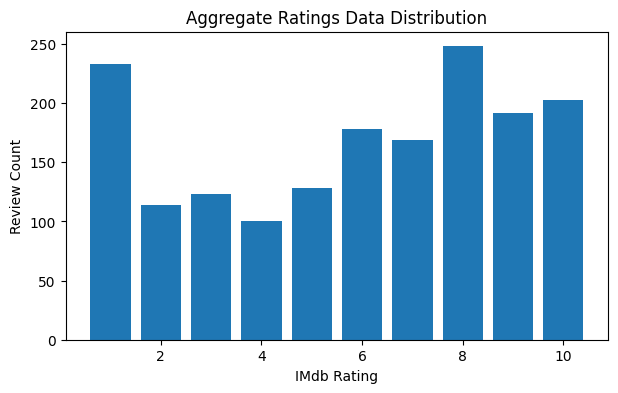

In [10]:
plt.figure(figsize=(7,4))
plt.bar(da.rating, da.review_count)
plt.title("Aggregate Ratings Data Distribution")
plt.xlabel("IMdb Rating")
plt.ylabel("Review Count")
plt.savefig('graph_Aggregate Ratings Data Distribution.png', dpi=300, bbox_inches='tight')

In [11]:
#extract the fisrt word in genre column
fl['f_genre'] = fl['genre'].apply(lambda x: x.split(',')[0])
fl['f_genre'] = fl['f_genre'].apply(lambda x: x.replace('[', '').replace(']', '').replace("'", ''))

<Axes: xlabel='rating', ylabel='Density'>

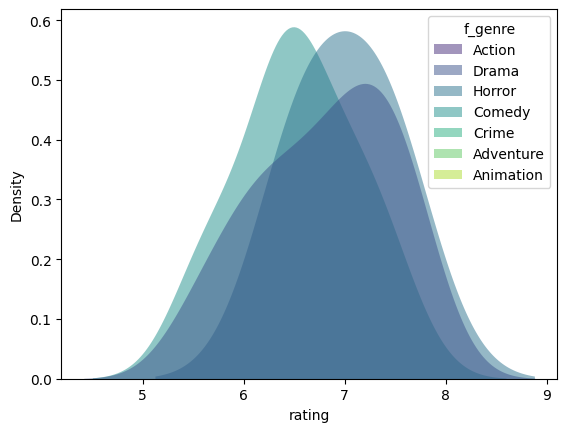

In [12]:
sns.kdeplot(
   data=fl, x="rating", hue="f_genre",
   fill=True, common_norm=False, palette="viridis",
   alpha=.5, linewidth=0,
)

# Pre-Process

In [13]:
#preprocess steps and cleaning


#clean the text in review column by removing any [~.,%/:;?_&+*=!-]
def preprocess_text(text):
    cleaned = re.sub(r'[~.,%/:;?_&+*=!-]', '', text)
    return cleaned

def data_cleaning(df):

    df['review'] = df['review'].apply(preprocess_text)

    #tokenization
    from nltk import word_tokenize,sent_tokenize 
    df['text_1'] = df['review'].str.lower().apply(word_tokenize)

    #stopwords removal
    stop_words = set(stopwords.words('english'))
    df['text_1'] = df['text_1'].apply(lambda x: [word for word in x if word.isalpha() and word not in stop_words])

    #lemmatization
    df["text_lmt"] = df["text_1"].apply(lambda x: [lmtsr.lemmatize(word) for word in x])

    #stemming
    ps = PorterStemmer()
    df["text_stm"] = df["text_1"].apply(lambda x: [ps.stem(word) for word in x])

    df['text_stm'] = df['text_stm'].astype(str)
        
    df[".len_text"] = df["text_lmt"].str.len()
    return df

cleaned_df = data_cleaning(data)
cleaned_df


,review_date,author,rating,review_title,review,review_url,film_title,text_1,text_lmt,text_stm,.len_text
0,2 May 2022,movieman_kev,9.0,best film of 2022\n,Profoundly deep genuinely moving utterly hilar...,/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022),"[profoundly, deep, genuinely, moving, utterly,...","[profoundly, deep, genuinely, moving, utterly,...","['profoundli', 'deep', 'genuin', 'move', 'utte...",23
1,24 May 2022,evanston_dad,9.0,Felt Like I Was Seeing the Inside of My Own M...,I have trouble turning off my brain Anxieties ...,/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022),"[trouble, turning, brain, anxieties, worries, ...","[trouble, turning, brain, anxiety, worry, mund...","['troubl', 'turn', 'brain', 'anxieti', 'worri'...",25
2,8 April 2022,AfricanBro,9.0,"Don't do drugs, watch this instead.\n",If you take drugs for the first time and imagi...,/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022),"[take, drugs, first, time, imagined, jackie, c...","[take, drug, first, time, imagined, jackie, ch...","['take', 'drug', 'first', 'time', 'imagin', 'j...",89
3,20 April 2022,gbill-74877,10.0,Fantastic\n,"""Be kind especially when you don't know what's...",/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022),"[kind, especially, know, going]","[kind, especially, know, going]","['kind', 'especi', 'know', 'go']",4
4,31 March 2022,benjaminskylerhill,10.0,The most original film ever made. Period.\n,Everything Everywhere All At Once is even craz...,/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022),"[everything, everywhere, even, crazier, traile...","[everything, everywhere, even, crazier, traile...","['everyth', 'everywher', 'even', 'crazier', 't...",29
...,...,...,...,...,...,...,...,...,...,...,...
1761,24 May 2019,bastille-852-731547,6.0,Okay but Somewhat Disappointing Drama\n,As much as I enjoy the betterquality summer bl...,/review/rw5365158/?ref_=tt_urv,The Souvenir (2019),"[much, enjoy, betterquality, summer, blockbust...","[much, enjoy, betterquality, summer, blockbust...","['much', 'enjoy', 'betterqu', 'summer', 'block...",40
1762,8 June 2019,mamlukman,1.0,Warning: Do NOT see!\n,My wife and I see about 8090 movies (in theate...,/review/rw5365158/?ref_=tt_urv,The Souvenir (2019),"[wife, see, movies, theatersnot, dvd, tv, ever...","[wife, see, movie, theatersnot, dvd, tv, every...","['wife', 'see', 'movi', 'theatersnot', 'dvd', ...",17
1763,16 May 2019,ferguson-6,8.0,welcome another talented Swinton\n,Greetings again from the darkness Viewers of w...,/review/rw5365158/?ref_=tt_urv,The Souvenir (2019),"[greetings, darkness, viewers, writerdirector,...","[greeting, darkness, viewer, writerdirector, j...","['greet', 'dark', 'viewer', 'writerdirector', ...",53
1764,22 February 2020,Go6565,1.0,Pointless\n,I wish I had read the user reviews (instead of...,/review/rw5365158/?ref_=tt_urv,The Souvenir (2019),"[wish, read, user, reviews, instead, professio...","[wish, read, user, review, instead, profession...","['wish', 'read', 'user', 'review', 'instead', ...",47


# TF-IDF

In [14]:
cleaned_df_gp  = cleaned_df.groupby('film_title').count()
cleaned_df_gp

,review_date,author,rating,review_title,review,review_url,text_1,text_lmt,text_stm,.len_text
film_title,,,,,,,,,,
After Yang (2021),25,25,24,25,25,25,25,25,25,25
Aftersun (2022),25,25,25,25,25,25,25,25,25,25
Bodies Bodies Bodies (2022),50,50,49,50,50,50,50,50,50,50
C'mon C'mon (2021),25,25,24,25,25,25,25,25,25,25
Causeway (2022),25,25,25,25,25,25,25,25,25,25
Close (2022),25,25,25,25,25,25,25,25,25,25
Everything Everywhere All at Once (2022),275,275,259,275,275,275,275,275,275,275
First Cow (2019),25,25,21,25,25,25,25,25,25,25
God's Creatures (2022),25,25,23,25,25,25,25,25,25,25


In [15]:
#bag of words and TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
bag_of_words = vectorizer.fit_transform(cleaned_df['text_stm'])

feature_names = vectorizer.get_feature_names_out()

# create a new dataframe with the bag of words representation
tf = pd.DataFrame(bag_of_words.toarray(), columns = vectorizer.get_feature_names_out())
tfidf_sum = tf.T.sum(axis=1).sort_values(ascending = False).reset_index().rename(columns={"index": "word", 0: "tfidf_sum"})
tfidf_transposed = tf.T

display(tf)

,aarrgg,ab,abandon,abba,abel,abil,abl,ablaz,abli,abnorm,...,zombi,zombieland,zone,zoo,zsolt,ättestupa,åström,élie,émili,übercliché
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Sentiment Analysis

In [16]:
sentiment_df = cleaned_df.copy()
#reset the index and call it id
sentiment_df.reset_index(inplace=True)
sentiment_df.rename(columns={'index': 'id'}, inplace=True)

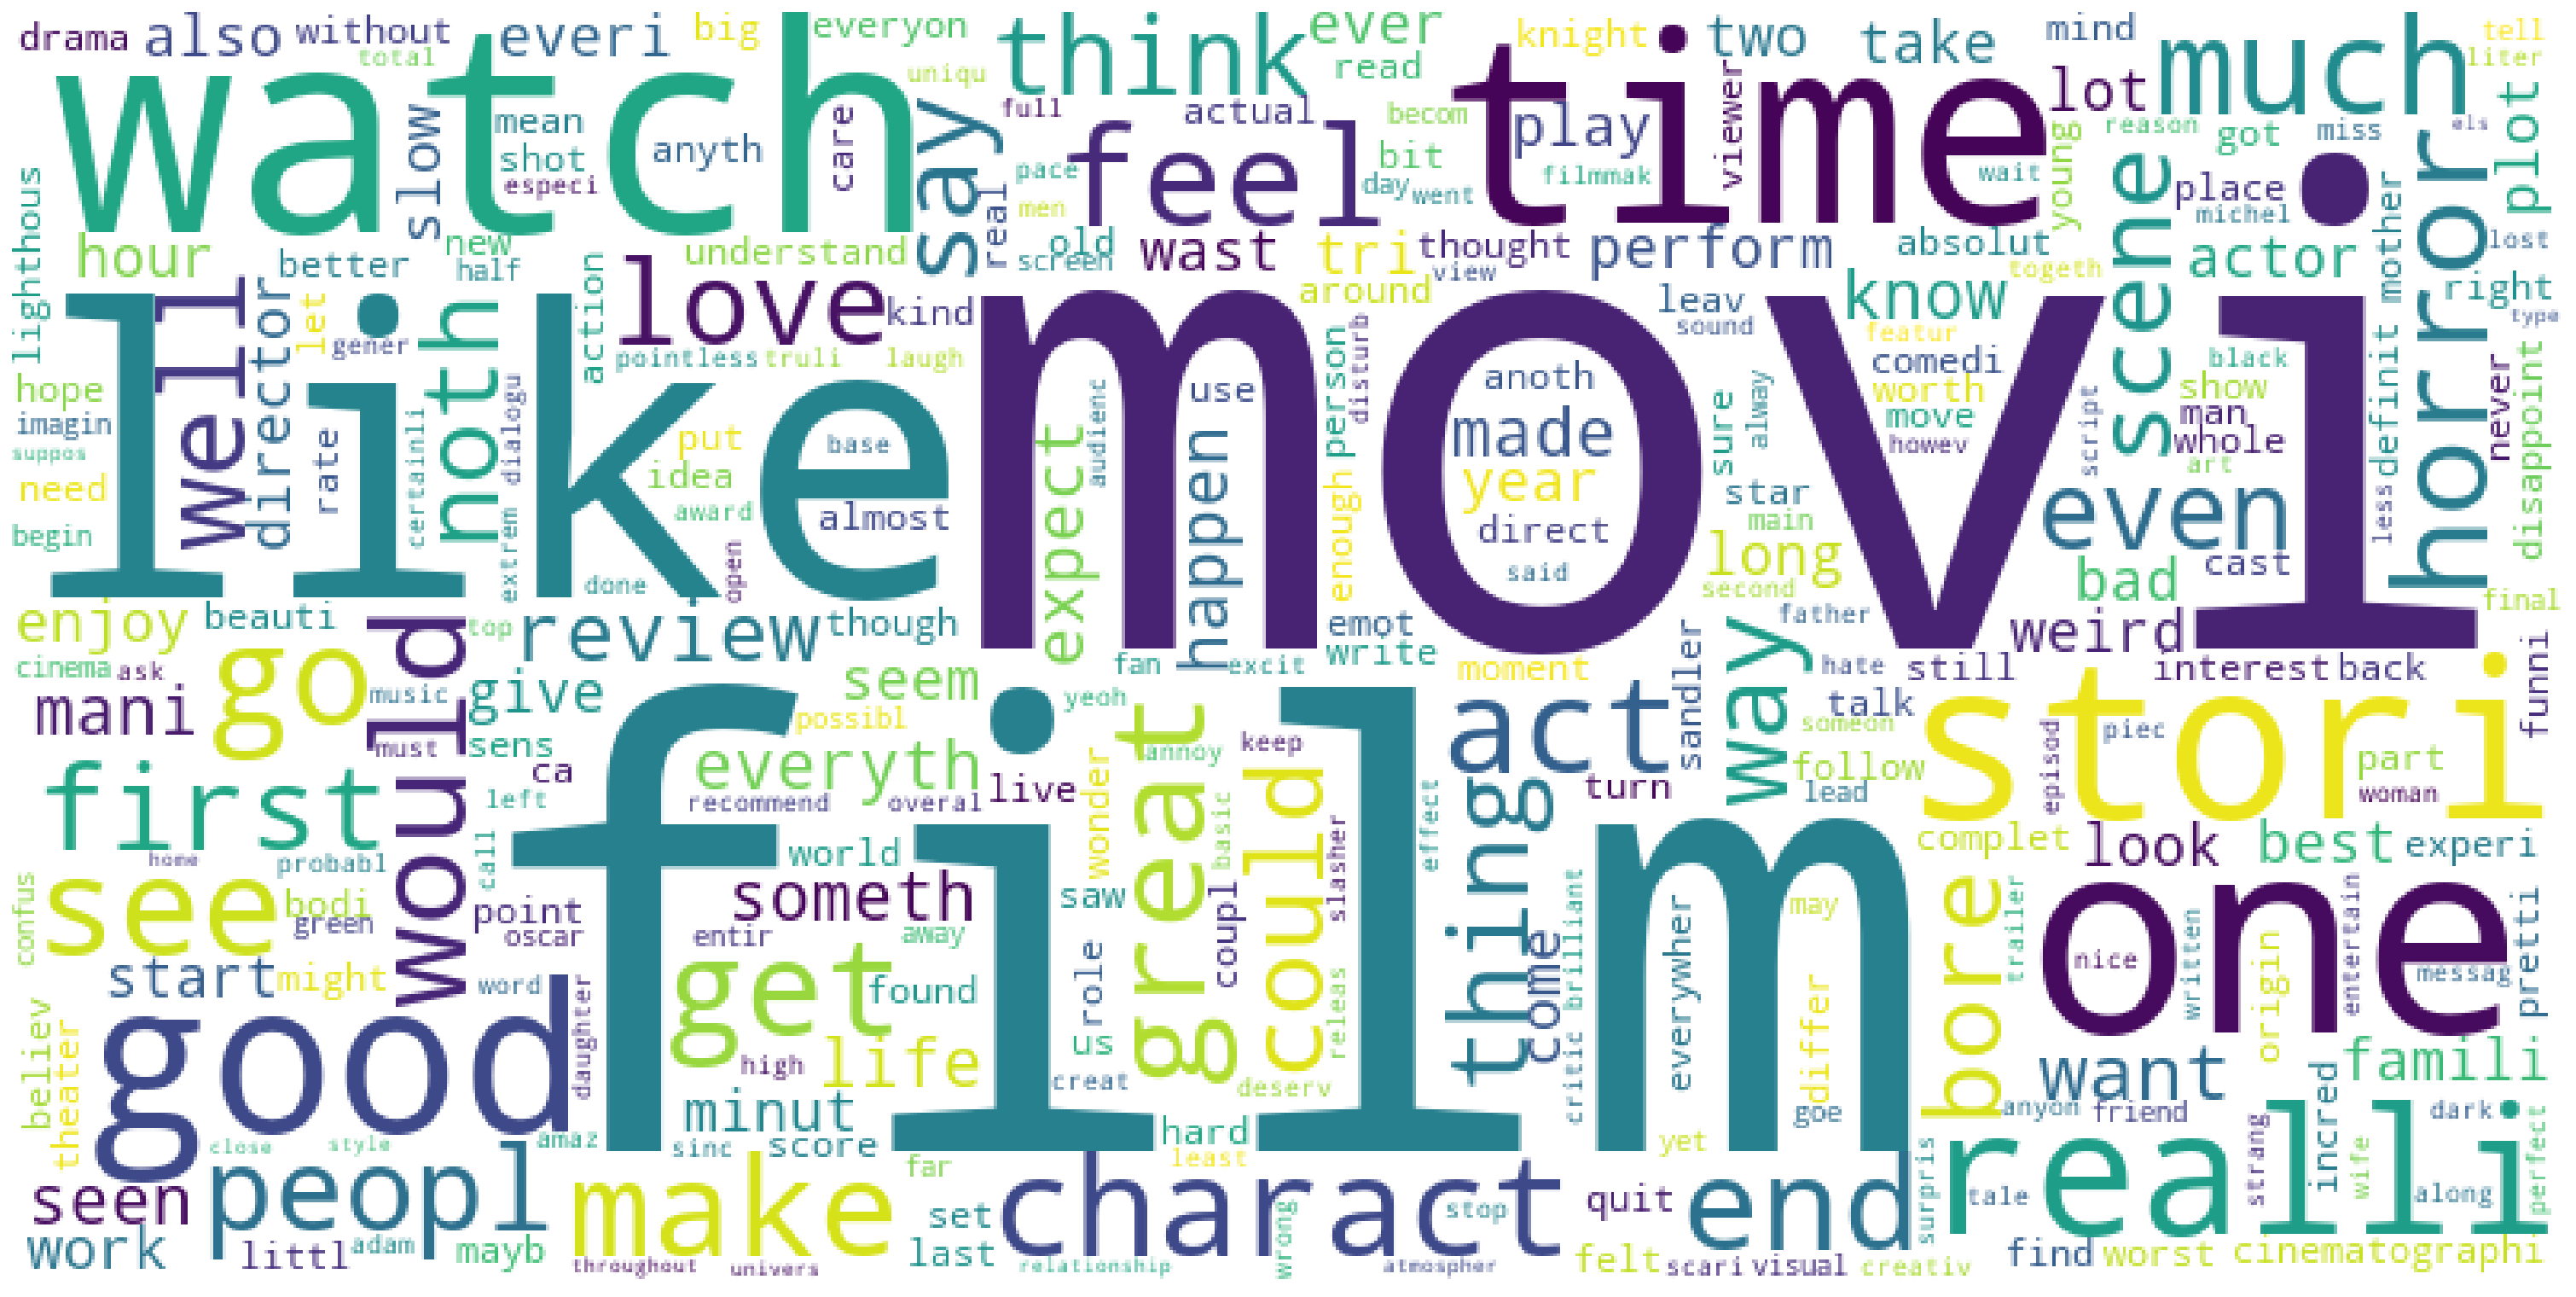

In [17]:
from wordcloud import WordCloud, STOPWORDS 

def wordcloud(df, max_words):
    wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=max_words, random_state=1).generate_from_frequencies(df.T.sum(axis=1))
    plt.figure(figsize = (30, 30), facecolor = 'white', edgecolor='blue') 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    plt.show()

wordcloud(tf, 300)

Basic NLTK stuff

In [18]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/matthewbaber/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [19]:
from textblob import TextBlob, Word, Blobber
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [20]:

res = {}
for i, row in tqdm(sentiment_df.iterrows(), total=len(sentiment_df)):
    text = row['review']
    myid = row['id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/1766 [00:00<?, ?it/s]

In [21]:
vaders = pd.DataFrame.from_dict(res).T
vaders = vaders.reset_index().rename(columns={'index':'id'})
vaders = vaders.merge(sentiment_df, how='left')
vaders

,id,neg,neu,pos,compound,review_date,author,rating,review_title,review,review_url,film_title,text_1,text_lmt,text_stm,.len_text
0,0,0.138,0.799,0.063,-0.3792,2 May 2022,movieman_kev,9.0,best film of 2022\n,Profoundly deep genuinely moving utterly hilar...,/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022),"[profoundly, deep, genuinely, moving, utterly,...","[profoundly, deep, genuinely, moving, utterly,...","['profoundli', 'deep', 'genuin', 'move', 'utte...",23
1,1,0.215,0.583,0.202,-0.1531,24 May 2022,evanston_dad,9.0,Felt Like I Was Seeing the Inside of My Own M...,I have trouble turning off my brain Anxieties ...,/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022),"[trouble, turning, brain, anxieties, worries, ...","[trouble, turning, brain, anxiety, worry, mund...","['troubl', 'turn', 'brain', 'anxieti', 'worri'...",25
2,2,0.086,0.751,0.162,0.9640,8 April 2022,AfricanBro,9.0,"Don't do drugs, watch this instead.\n",If you take drugs for the first time and imagi...,/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022),"[take, drugs, first, time, imagined, jackie, c...","[take, drug, first, time, imagined, jackie, ch...","['take', 'drug', 'first', 'time', 'imagin', 'j...",89
3,3,0.000,0.726,0.274,0.5267,20 April 2022,gbill-74877,10.0,Fantastic\n,"""Be kind especially when you don't know what's...",/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022),"[kind, especially, know, going]","[kind, especially, know, going]","['kind', 'especi', 'know', 'go']",4
4,4,0.092,0.804,0.104,0.5658,31 March 2022,benjaminskylerhill,10.0,The most original film ever made. Period.\n,Everything Everywhere All At Once is even craz...,/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022),"[everything, everywhere, even, crazier, traile...","[everything, everywhere, even, crazier, traile...","['everyth', 'everywher', 'even', 'crazier', 't...",29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1761,1761,0.049,0.639,0.312,0.9742,24 May 2019,bastille-852-731547,6.0,Okay but Somewhat Disappointing Drama\n,As much as I enjoy the betterquality summer bl...,/review/rw5365158/?ref_=tt_urv,The Souvenir (2019),"[much, enjoy, betterquality, summer, blockbust...","[much, enjoy, betterquality, summer, blockbust...","['much', 'enjoy', 'betterqu', 'summer', 'block...",40
1762,1762,0.111,0.707,0.182,0.1531,8 June 2019,mamlukman,1.0,Warning: Do NOT see!\n,My wife and I see about 8090 movies (in theate...,/review/rw5365158/?ref_=tt_urv,The Souvenir (2019),"[wife, see, movies, theatersnot, dvd, tv, ever...","[wife, see, movie, theatersnot, dvd, tv, every...","['wife', 'see', 'movi', 'theatersnot', 'dvd', ...",17
1763,1763,0.047,0.740,0.213,0.9584,16 May 2019,ferguson-6,8.0,welcome another talented Swinton\n,Greetings again from the darkness Viewers of w...,/review/rw5365158/?ref_=tt_urv,The Souvenir (2019),"[greetings, darkness, viewers, writerdirector,...","[greeting, darkness, viewer, writerdirector, j...","['greet', 'dark', 'viewer', 'writerdirector', ...",53
1764,1764,0.076,0.780,0.144,0.7469,22 February 2020,Go6565,1.0,Pointless\n,I wish I had read the user reviews (instead of...,/review/rw5365158/?ref_=tt_urv,The Souvenir (2019),"[wish, read, user, reviews, instead, professio...","[wish, read, user, review, instead, profession...","['wish', 'read', 'user', 'review', 'instead', ...",47


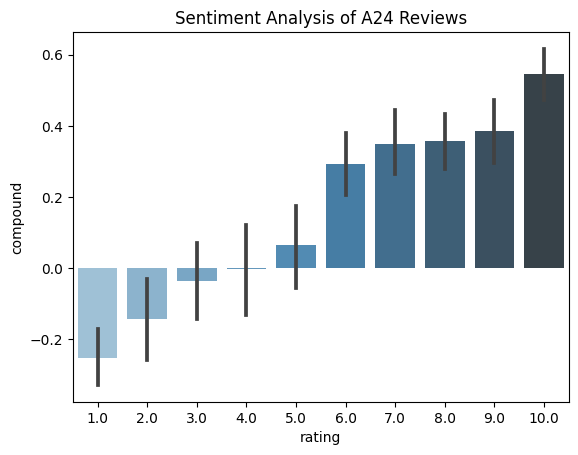

In [22]:
ax = sns.barplot(data=vaders, x='rating', y='compound', palette='Blues_d')
ax.set_title('Sentiment Analysis of A24 Reviews')
plt.show()

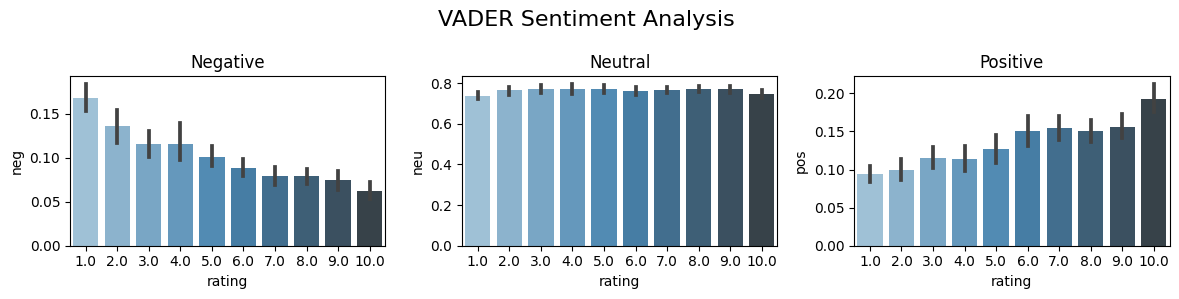

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
fig.suptitle('VADER Sentiment Analysis', fontsize=16)
sns.barplot(data=vaders, x='rating', y='neg', palette='Blues_d', ax=axs[0])
sns.barplot(data=vaders, x='rating', y='neu', palette='Blues_d', ax=axs[1])
sns.barplot(data=vaders, x='rating', y='pos', palette='Blues_d', ax=axs[2])
axs[0].set_title('Negative')
axs[1].set_title('Neutral')
axs[2].set_title('Positive')
plt.tight_layout()
plt.show()

In [24]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

In [25]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [26]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
}
    return scores_dict

In [27]:
res2 = {}
for i, row in tqdm(sentiment_df.iterrows(), total=len(sentiment_df)):
    try:
        text = row['review']
        myid = row['id']

        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        
        roberta_results = polarity_scores_roberta(text)

        both = {**vader_result_rename, **roberta_results}
        res2[myid] = both
    except RuntimeError:
        print(f"RuntimeError on {myid}")

  0%|          | 0/1766 [00:00<?, ?it/s]

RuntimeError on 104
RuntimeError on 184
RuntimeError on 412
RuntimeError on 543
RuntimeError on 647
RuntimeError on 954
RuntimeError on 1051
RuntimeError on 1079
RuntimeError on 1095
RuntimeError on 1745


In [28]:
query_request = sentiment_df.query('index == 104 or index == 184 or index == 412 or index == 543 or index == 647 or index == 954 or index == 1051 or index == 1079 or index == 1095 or index == 1745')
query_request

,id,review_date,author,rating,review_title,review,review_url,film_title,text_1,text_lmt,text_stm,.len_text
104,104,18 September 2022,Pjtaylor-96-138044,8.0,Open your third (googly) eye...\n,Overwhelming in scale yet intimate in scope 'E...,/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022),"[overwhelming, scale, yet, intimate, scope, ev...","[overwhelming, scale, yet, intimate, scope, ev...","['overwhelm', 'scale', 'yet', 'intim', 'scope'...",325
184,184,12 March 2023,jboothmillard,8.0,Everything Everywhere All at Once\n,I knew this film was a big deal during its tim...,/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022),"[knew, film, big, deal, time, cinema, online, ...","[knew, film, big, deal, time, cinema, online, ...","['knew', 'film', 'big', 'deal', 'time', 'cinem...",708
412,412,7 July 2019,Pjtaylor-96-138044,4.0,One bad trip.\n,'Midsommar (2019)' takes a very long time to g...,/review/rw5561163/?ref_=tt_urv,Midsommar (2019),"[takes, long, time, get, predictable, frankly,...","[take, long, time, get, predictable, frankly, ...","['take', 'long', 'time', 'get', 'predict', 'fr...",217
543,543,14 July 2019,jboothmillard,5.0,Midsommar\n,This scary movie was becoming something of a t...,/review/rw5561163/?ref_=tt_urv,Midsommar (2019),"[scary, movie, becoming, something, talking, p...","[scary, movie, becoming, something, talking, p...","['scari', 'movi', 'becom', 'someth', 'talk', '...",499
647,647,17 September 2022,jboothmillard,5.0,Bodies Bodies Bodies\n,I saw the trailer a short time before this fil...,/review/rw8629009/?ref_=tt_urv,Bodies Bodies Bodies (2022),"[saw, trailer, short, time, film, release, ass...","[saw, trailer, short, time, film, release, ass...","['saw', 'trailer', 'short', 'time', 'film', 'r...",456
954,954,15 June 2022,jboothmillard,4.0,Men\n,I thought maybe the film was a dark twisted ta...,/review/rw8173612/?ref_=tt_urv,Men (2022),"[thought, maybe, film, dark, twisted, take, ph...","[thought, maybe, film, dark, twisted, take, ph...","['thought', 'mayb', 'film', 'dark', 'twist', '...",596
1051,1051,17 July 2020,ironhorse_iv,8.0,The Lighthouse is a shining example of a semi...,It's time to shed some light into this A24 mot...,/review/rw5927914/?ref_=tt_urv,The Lighthouse (2019),"[time, shed, light, motion, picture, directed,...","[time, shed, light, motion, picture, directed,...","['time', 'shed', 'light', 'motion', 'pictur', ...",465
1079,1079,20 October 2019,grantpaulsen,10.0,The Best Film of 2019 So Far\n,This film is a psychological horror masterpiec...,/review/rw5927914/?ref_=tt_urv,The Lighthouse (2019),"[film, psychological, horror, masterpiece, fil...","[film, psychological, horror, masterpiece, fil...","['film', 'psycholog', 'horror', 'masterpiec', ...",257
1095,1095,6 November 2019,theredsky,10.0,The Lighthouse Review\n,Not only is The Lighthouse a masterpiece it's ...,/review/rw5927914/?ref_=tt_urv,The Lighthouse (2019),"[lighthouse, masterpiece, favorite, film, year...","[lighthouse, masterpiece, favorite, film, year...","['lighthous', 'masterpiec', 'favorit', 'film',...",276
1745,1745,24 October 2019,Gilly-13,8.0,"I had to ""solve"" this film, but it was worth ...",Like many I was bored and confused after viewi...,/review/rw5365158/?ref_=tt_urv,The Souvenir (2019),"[like, many, bored, confused, viewing, souveni...","[like, many, bored, confused, viewing, souveni...","['like', 'mani', 'bore', 'confus', 'view', 'so...",268


In [29]:
res2 = pd.DataFrame.from_dict(res2).T
res2

,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
0,0.138,0.799,0.063,-0.3792,0.005127,0.024844,0.970029
1,0.215,0.583,0.202,-0.1531,0.854076,0.129466,0.016459
2,0.086,0.751,0.162,0.9640,0.021825,0.089965,0.888211
3,0.000,0.726,0.274,0.5267,0.307210,0.565948,0.126843
4,0.092,0.804,0.104,0.5658,0.024468,0.091965,0.883567
...,...,...,...,...,...,...,...
1761,0.049,0.639,0.312,0.9742,0.154799,0.288335,0.556866
1762,0.111,0.707,0.182,0.1531,0.938957,0.053684,0.007358
1763,0.047,0.740,0.213,0.9584,0.007885,0.088672,0.903443
1764,0.076,0.780,0.144,0.7469,0.762345,0.185355,0.052300


In [30]:
res2 = res2.reset_index().rename(columns={'index': 'id'})
res2 = res2.merge(sentiment_df, how='left', on='id')
res2

,id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,review_date,author,rating,review_title,review,review_url,film_title,text_1,text_lmt,text_stm,.len_text
0,0,0.138,0.799,0.063,-0.3792,0.005127,0.024844,0.970029,2 May 2022,movieman_kev,9.0,best film of 2022\n,Profoundly deep genuinely moving utterly hilar...,/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022),"[profoundly, deep, genuinely, moving, utterly,...","[profoundly, deep, genuinely, moving, utterly,...","['profoundli', 'deep', 'genuin', 'move', 'utte...",23
1,1,0.215,0.583,0.202,-0.1531,0.854076,0.129466,0.016459,24 May 2022,evanston_dad,9.0,Felt Like I Was Seeing the Inside of My Own M...,I have trouble turning off my brain Anxieties ...,/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022),"[trouble, turning, brain, anxieties, worries, ...","[trouble, turning, brain, anxiety, worry, mund...","['troubl', 'turn', 'brain', 'anxieti', 'worri'...",25
2,2,0.086,0.751,0.162,0.9640,0.021825,0.089965,0.888211,8 April 2022,AfricanBro,9.0,"Don't do drugs, watch this instead.\n",If you take drugs for the first time and imagi...,/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022),"[take, drugs, first, time, imagined, jackie, c...","[take, drug, first, time, imagined, jackie, ch...","['take', 'drug', 'first', 'time', 'imagin', 'j...",89
3,3,0.000,0.726,0.274,0.5267,0.307210,0.565948,0.126843,20 April 2022,gbill-74877,10.0,Fantastic\n,"""Be kind especially when you don't know what's...",/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022),"[kind, especially, know, going]","[kind, especially, know, going]","['kind', 'especi', 'know', 'go']",4
4,4,0.092,0.804,0.104,0.5658,0.024468,0.091965,0.883567,31 March 2022,benjaminskylerhill,10.0,The most original film ever made. Period.\n,Everything Everywhere All At Once is even craz...,/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022),"[everything, everywhere, even, crazier, traile...","[everything, everywhere, even, crazier, traile...","['everyth', 'everywher', 'even', 'crazier', 't...",29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1751,1761,0.049,0.639,0.312,0.9742,0.154799,0.288335,0.556866,24 May 2019,bastille-852-731547,6.0,Okay but Somewhat Disappointing Drama\n,As much as I enjoy the betterquality summer bl...,/review/rw5365158/?ref_=tt_urv,The Souvenir (2019),"[much, enjoy, betterquality, summer, blockbust...","[much, enjoy, betterquality, summer, blockbust...","['much', 'enjoy', 'betterqu', 'summer', 'block...",40
1752,1762,0.111,0.707,0.182,0.1531,0.938957,0.053684,0.007358,8 June 2019,mamlukman,1.0,Warning: Do NOT see!\n,My wife and I see about 8090 movies (in theate...,/review/rw5365158/?ref_=tt_urv,The Souvenir (2019),"[wife, see, movies, theatersnot, dvd, tv, ever...","[wife, see, movie, theatersnot, dvd, tv, every...","['wife', 'see', 'movi', 'theatersnot', 'dvd', ...",17
1753,1763,0.047,0.740,0.213,0.9584,0.007885,0.088672,0.903443,16 May 2019,ferguson-6,8.0,welcome another talented Swinton\n,Greetings again from the darkness Viewers of w...,/review/rw5365158/?ref_=tt_urv,The Souvenir (2019),"[greetings, darkness, viewers, writerdirector,...","[greeting, darkness, viewer, writerdirector, j...","['greet', 'dark', 'viewer', 'writerdirector', ...",53
1754,1764,0.076,0.780,0.144,0.7469,0.762345,0.185355,0.052300,22 February 2020,Go6565,1.0,Pointless\n,I wish I had read the user reviews (instead of...,/review/rw5365158/?ref_=tt_urv,The Souvenir (2019),"[wish, read, user, reviews, instead, professio...","[wish, read, user, review, instead, profession...","['wish', 'read', 'user', 'review', 'instead', ...",47


In [19]:
res = res2.copy()
#save as csv
res.to_csv('res.csv', index=False)
res = pd.read_csv('res.csv')

NameError: name 'res2' is not defined

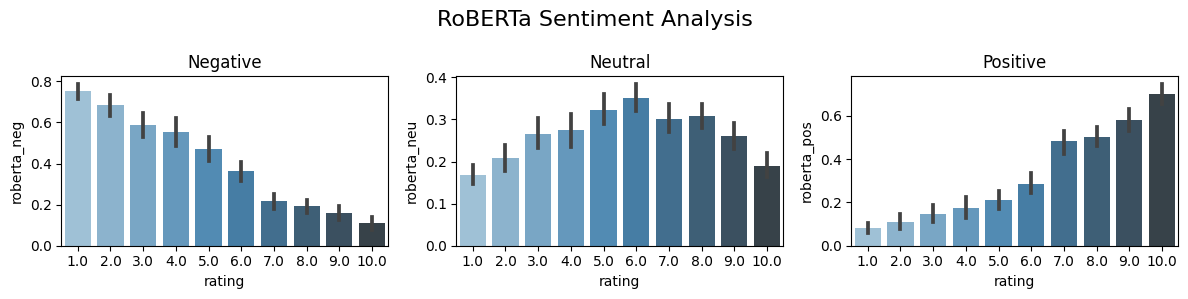

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
fig.suptitle('RoBERTa Sentiment Analysis', fontsize=16)
sns.barplot(data=res, x='rating', y='roberta_neg', palette='Blues_d', ax=axs[0])
sns.barplot(data=res, x='rating', y='roberta_neu', palette='Blues_d', ax=axs[1])
sns.barplot(data=res, x='rating', y='roberta_pos', palette='Blues_d', ax=axs[2])
axs[0].set_title('Negative')
axs[1].set_title('Neutral')
axs[2].set_title('Positive')
plt.tight_layout()
plt.show()

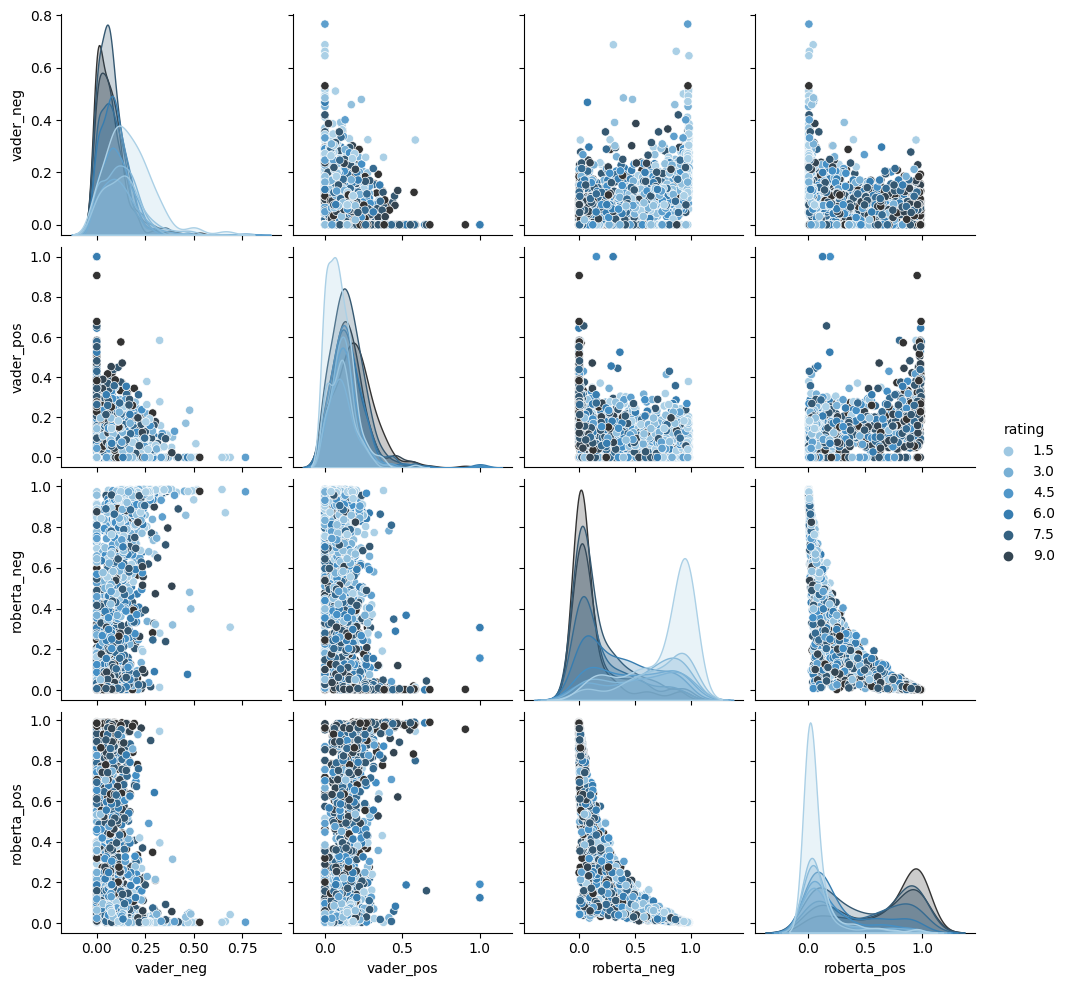

In [33]:
sns.pairplot(data=res, vars=['vader_neg', 'vader_pos',
       'roberta_neg', 'roberta_pos'], hue='rating', palette='Blues_d')
plt.show()

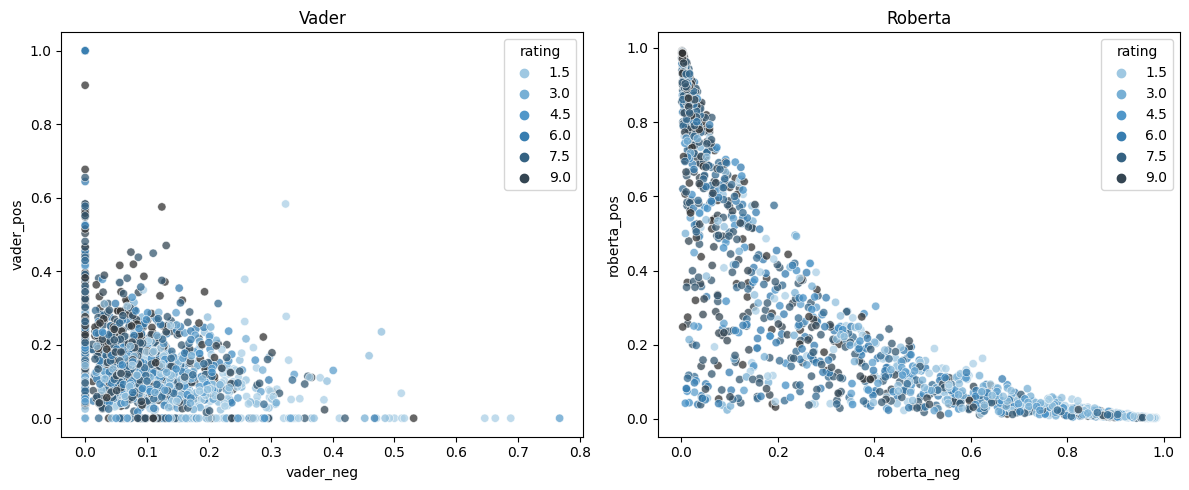

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(data=res, x='vader_neg', y='vader_pos', hue='rating', alpha=0.75, palette='Blues_d',ax=axs[0])
sns.scatterplot(data=res, x='roberta_neg', y='roberta_pos', hue='rating', alpha=0.75, palette='Blues_d',ax=axs[1])
axs[0].set_title('Vader')
axs[1].set_title('Roberta')
plt.tight_layout()
plt.show()
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

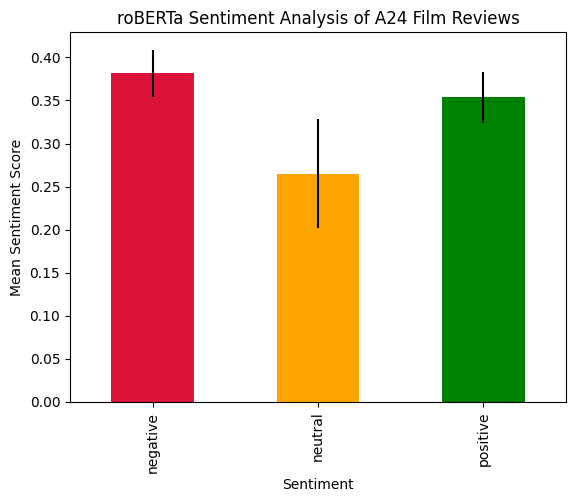

In [35]:
sentiment_dict = {
    "negative": res["roberta_neg"].mean(),
    "neutral": res["roberta_neu"].mean(),
    "positive": res["roberta_pos"].mean()
}

sentiment_dff = pd.DataFrame(sentiment_dict, index=[0]).T

# get sentiment summary statistics
sentiment_stats = res[["roberta_neg", "roberta_neu", "roberta_pos"]].describe().loc[["25%", "50%", "75%"]]

# plot mean sentiment scores with error bars showing 25th and 75th percentiles
colors = ["crimson", "orange", "green"]
ax = sentiment_dff.plot(kind="bar", y=0, title="roBERTa Sentiment Analysis of A24 Film Reviews", legend=False, color=colors, yerr=sentiment_stats.values)

# add axis labels
ax.set_xlabel("Sentiment")
ax.set_ylabel("Mean Sentiment Score")

plt.show()

# Training

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(ngram_range=(2,2), max_features=500000)

import sklearn.linear_model


In [20]:
res = pd.read_csv('res.csv')

In [21]:
res['text_prepared'] = res['text_stm'].str.replace('[', '').str.replace(']', '').str.replace("'", "").str.replace(",", "")
res['roberta_sentiment'] = np.where(res['roberta_pos'] > res['roberta_neg'], 'positive', 'negative')
res['vader_sentiment'] = np.where(res['vader_pos'] > res['vader_neg'], 'positive', 'negative')
print(res['vader_sentiment'].value_counts())
print(res['roberta_sentiment'].value_counts())
res['const'] = 1
res

positive    1045
negative     711
Name: vader_sentiment, dtype: int64
negative    941
positive    815
Name: roberta_sentiment, dtype: int64


,id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,review_date,author,...,review_url,film_title,text_1,text_lmt,text_stm,.len_text,text_prepared,roberta_sentiment,vader_sentiment,const
0,0,0.138,0.799,0.063,-0.3792,0.005127,0.024844,0.970029,2 May 2022,movieman_kev,...,/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022),"['profoundly', 'deep', 'genuinely', 'moving', ...","['profoundly', 'deep', 'genuinely', 'moving', ...","['profoundli', 'deep', 'genuin', 'move', 'utte...",23,profoundli deep genuin move utterli hilari hig...,positive,negative,1
1,1,0.215,0.583,0.202,-0.1531,0.854076,0.129466,0.016459,24 May 2022,evanston_dad,...,/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022),"['trouble', 'turning', 'brain', 'anxieties', '...","['trouble', 'turning', 'brain', 'anxiety', 'wo...","['troubl', 'turn', 'brain', 'anxieti', 'worri'...",25,troubl turn brain anxieti worri mundan todo ev...,negative,negative,1
2,2,0.086,0.751,0.162,0.9640,0.021825,0.089965,0.888211,8 April 2022,AfricanBro,...,/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022),"['take', 'drugs', 'first', 'time', 'imagined',...","['take', 'drug', 'first', 'time', 'imagined', ...","['take', 'drug', 'first', 'time', 'imagin', 'j...",89,take drug first time imagin jacki chan femal d...,positive,positive,1
3,3,0.000,0.726,0.274,0.5267,0.307210,0.565948,0.126843,20 April 2022,gbill-74877,...,/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022),"['kind', 'especially', 'know', 'going']","['kind', 'especially', 'know', 'going']","['kind', 'especi', 'know', 'go']",4,kind especi know go,negative,positive,1
4,4,0.092,0.804,0.104,0.5658,0.024468,0.091965,0.883567,31 March 2022,benjaminskylerhill,...,/review/rw8029183/?ref_=tt_urv,Everything Everywhere All at Once (2022),"['everything', 'everywhere', 'even', 'crazier'...","['everything', 'everywhere', 'even', 'crazier'...","['everyth', 'everywher', 'even', 'crazier', 't...",29,everyth everywher even crazier trailer would l...,positive,positive,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1751,1761,0.049,0.639,0.312,0.9742,0.154799,0.288335,0.556866,24 May 2019,bastille-852-731547,...,/review/rw5365158/?ref_=tt_urv,The Souvenir (2019),"['much', 'enjoy', 'betterquality', 'summer', '...","['much', 'enjoy', 'betterquality', 'summer', '...","['much', 'enjoy', 'betterqu', 'summer', 'block...",40,much enjoy betterqu summer blockbust also real...,positive,positive,1
1752,1762,0.111,0.707,0.182,0.1531,0.938957,0.053684,0.007358,8 June 2019,mamlukman,...,/review/rw5365158/?ref_=tt_urv,The Souvenir (2019),"['wife', 'see', 'movies', 'theatersnot', 'dvd'...","['wife', 'see', 'movie', 'theatersnot', 'dvd',...","['wife', 'see', 'movi', 'theatersnot', 'dvd', ...",17,wife see movi theatersnot dvd tv everi year go...,negative,positive,1
1753,1763,0.047,0.740,0.213,0.9584,0.007885,0.088672,0.903443,16 May 2019,ferguson-6,...,/review/rw5365158/?ref_=tt_urv,The Souvenir (2019),"['greetings', 'darkness', 'viewers', 'writerdi...","['greeting', 'darkness', 'viewer', 'writerdire...","['greet', 'dark', 'viewer', 'writerdirector', ...",53,greet dark viewer writerdirector joanna hogg s...,positive,positive,1
1754,1764,0.076,0.780,0.144,0.7469,0.762345,0.185355,0.052300,22 February 2020,Go6565,...,/review/rw5365158/?ref_=tt_urv,The Souvenir (2019),"['wish', 'read', 'user', 'reviews', 'instead',...","['wish', 'read', 'user', 'review', 'instead', ...","['wish', 'read', 'user', 'review', 'instead', ...",47,wish read user review instead profession revie...,negative,positive,1


In [24]:
X = res['text_prepared']
y = res['roberta_sentiment']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0) 

X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)

log_regression = LogisticRegression()

log_regression.fit(X_train,y_train)

X = vec.transform(X)

res['predict'] = log_regression.predict_proba(X)[::,1]

<Axes: xlabel='vader_compound', ylabel='predict'>

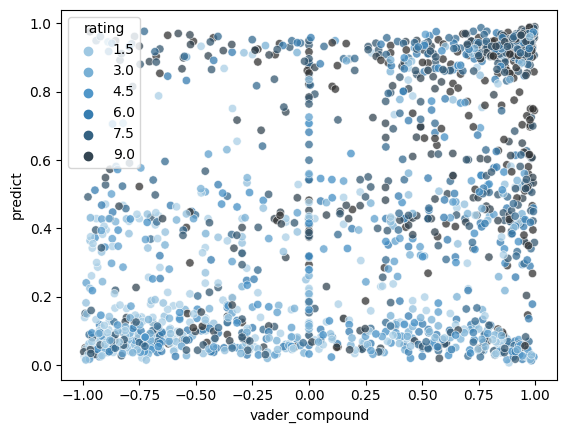

In [26]:
#plot predict agaisnt vader_compound
sns.scatterplot(data=res, x='vader_compound', y='predict', hue='rating', alpha=0.75, palette='Blues_d')

<Axes: xlabel='roberta_pos', ylabel='predict'>

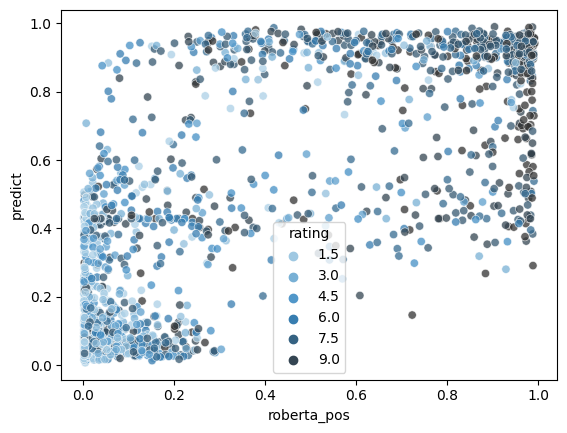

In [42]:
sns.scatterplot(data=res, x='roberta_pos', y='predict', hue='rating', alpha=0.75, palette='Blues_d')

In [44]:
cdf = res[['vader_neg', 'vader_pos', 'const', 'vader_sentiment']]
cdf['vader_sentiment'] = cdf['vader_sentiment'].map({'negative':0, 'positive':1})
cdf

clf_pipeline = make_pipeline(StandardScaler(),  LogisticRegression())

X = cdf.drop(columns=['vader_sentiment'])
y = cdf['vader_sentiment']

clf_pipeline.fit(X, y)

X['y_pred'] = clf_pipeline.predict(X)
X['y_true'] = y

In [45]:
X['predict'] = res['predict']

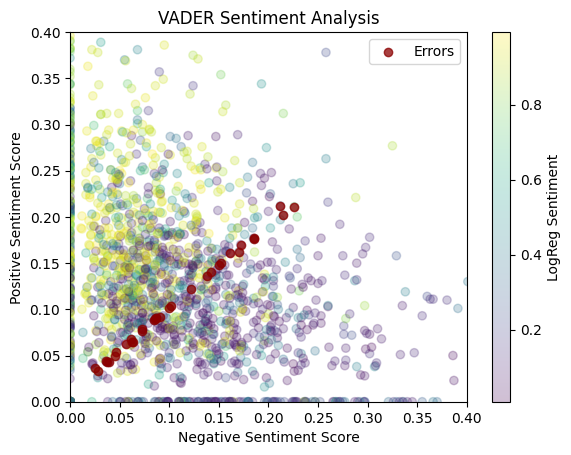

In [46]:
#create a scatter plot of the vader_neg and vader_pos columns
X['relation'] = np.where(X['y_pred'] == X['y_true'], 'correct', 'incorrect')
plt.scatter(X['vader_neg'], X['vader_pos'], c=X['predict'], alpha=0.25)

plt.colorbar(label='LogReg Sentiment Analysis')
plt.scatter(X[X['relation'] == 'incorrect']['vader_neg'], X[X['relation'] == 'incorrect']['vader_pos'], color='darkred', label='Errors', alpha=0.75)

# create axis labels
plt.title("VADER Sentiment Analysis")
plt.xlabel("Negative Sentiment Score")
plt.ylabel("Positive Sentiment Score")
plt.show

plt.xlim(0.0, 0.4)
plt.ylim(0.0, 0.4)

plt.legend()

plt.show()

In [50]:
cdf = res[['roberta_neg', 'roberta_pos', 'const', 'roberta_sentiment']]
cdf['roberta_sentiment'] = cdf['roberta_sentiment'].map({'negative':0, 'positive':1})
cdf

clf_pipeline = make_pipeline(StandardScaler(),  LogisticRegression())

X = cdf.drop(columns=['roberta_sentiment'])
y = cdf['roberta_sentiment']


clf_pipeline.fit(X, y)

X['y_pred'] = clf_pipeline.predict(X)
X['y_true'] = y

In [51]:
X['predict'] = res['predict']

<function matplotlib.pyplot.show(close=None, block=None)>

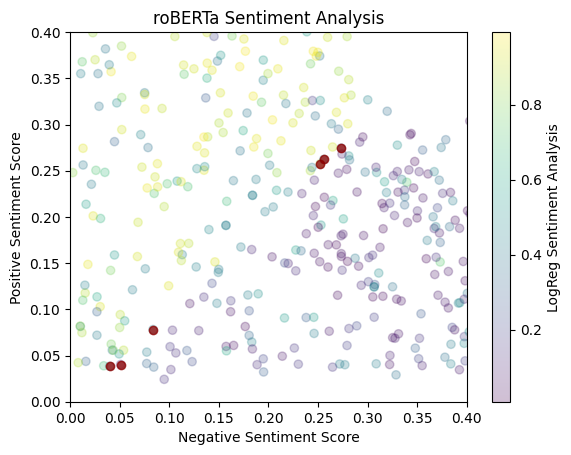

In [52]:
X['relation'] = np.where(X['y_pred'] == X['y_true'], 'correct', 'incorrect')
plt.scatter(X['roberta_neg'], X['roberta_pos'], c=X['predict'], alpha=0.25)
plt.colorbar(label='LogReg Sentiment Analysis')
plt.scatter(X[X['relation'] == 'incorrect']['roberta_neg'], X[X['relation'] == 'incorrect']['roberta_pos'], color='darkred', label='Errors', alpha=0.75)

# create axis labels
plt.title('roBERTa Sentiment Analysis')
plt.xlabel("Negative Sentiment Score")
plt.ylabel("Positive Sentiment Score")

# scale the axis from just 0.4 to 0.4
plt.xlim(0.0, 0.4)
plt.ylim(0.0, 0.4)

plt.show

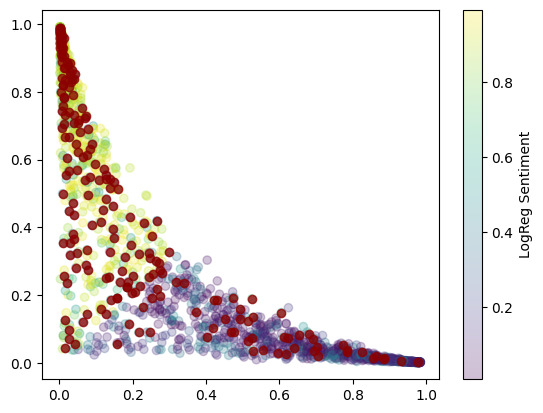

In [150]:
X['relation'] = np.where(X['y_pred'] == X['y_true'], 'correct', 'incorrect')
plt.scatter(res['roberta_neg'], res['roberta_pos'], c=res['predict'], alpha=0.25)
plt.colorbar(label='LogReg Sentiment')
plt.scatter(res[res['r_relation'] == 'incorrect']['roberta_neg'], res[res['r_relation'] == 'incorrect']['roberta_pos'], color='darkred', label='Errors', alpha=0.75)

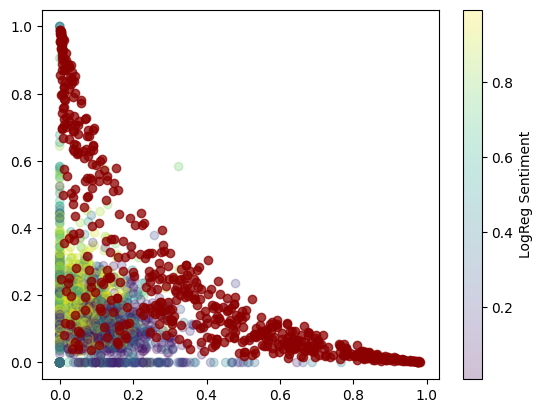

In [151]:
res['v_relation'] = np.where(res['vader_sentiment'] == res['predict_binary'], 'correct', 'incorrect')
plt.scatter(res['vader_neg'], res['vader_pos'], c=res['predict'], alpha=0.25)
plt.colorbar(label='LogReg Sentiment')
plt.scatter(res[res['v_relation'] == 'incorrect']['roberta_neg'], res[res['v_relation'] == 'incorrect']['roberta_pos'], color='darkred', label='Errors', alpha=0.75)

PCA

roBERTA

In [118]:
trainsize = 0.7
X = res['text_prepared']
y = res['roberta_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=1-trainsize,
                                         random_state=123)

In [119]:

X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)

Training Accuracy : 0.9926769731489016
Test Accuracy : 0.5351043643263758


<Axes: >

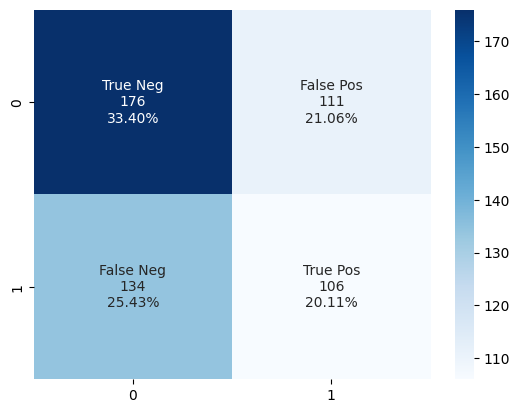

In [120]:
#model = LogisticRegression(max_iter=10000)
model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Training Accuracy :", model.score(X_train, y_train))
print("Test Accuracy :", model.score(X_test, y_test))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [134]:
X = res['text_prepared']
y = res['roberta_sentiment']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0) 

X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)

log_regression = LogisticRegression()

log_regression.fit(X_train,y_train)

log_regression.predict_proba(X_test)[::,1]

In [122]:
y_test = y_test.map({'positive': 1, 'negative': 0}).astype(int)

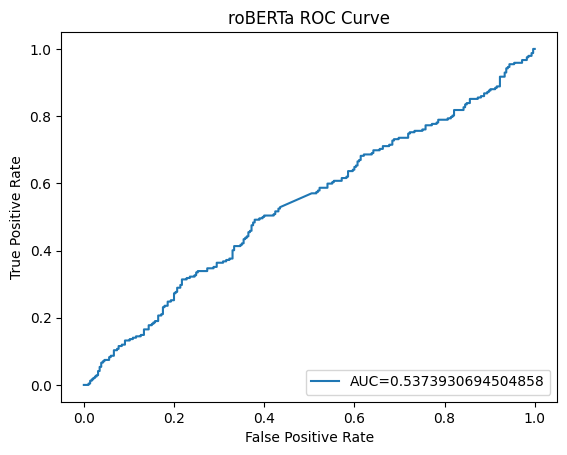

In [127]:
y_pred_proba = log_regression.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

auc= metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve

plt.plot(fpr, tpr,label="AUC="+str(auc))
plt.title('roBERTa ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)

VADERS

In [128]:
trainsize = 0.7
X = res['text_prepared']
y = res['vader_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=1-trainsize,
                                         random_state=123)

In [129]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(ngram_range=(2,2), max_features=500000)
X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)

Training Accuracy : 0.9877949552481693
Test Accuracy : 0.5370018975332068


<Axes: >

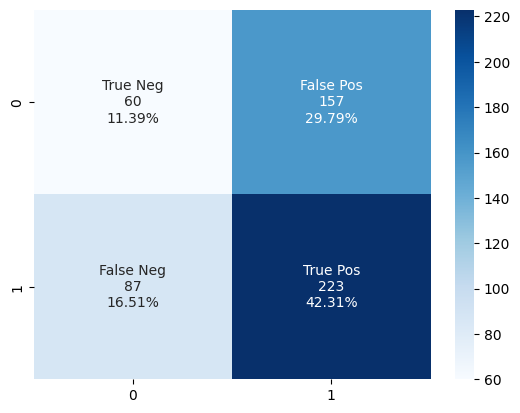

In [130]:
#model = LogisticRegression(max_iter=10000)
model = MultinomialNB()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Training Accuracy :", model.score(X_train, y_train))
print("Test Accuracy :", model.score(X_test, y_test))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [131]:
X = res['text_prepared']
y = res['vader_sentiment']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0) 

X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)

log_regression = LogisticRegression()

log_regression.fit(X_train,y_train)

LogisticRegression()

In [132]:
y_test = y_test.map({'positive': 1, 'negative': 0}).astype(int)

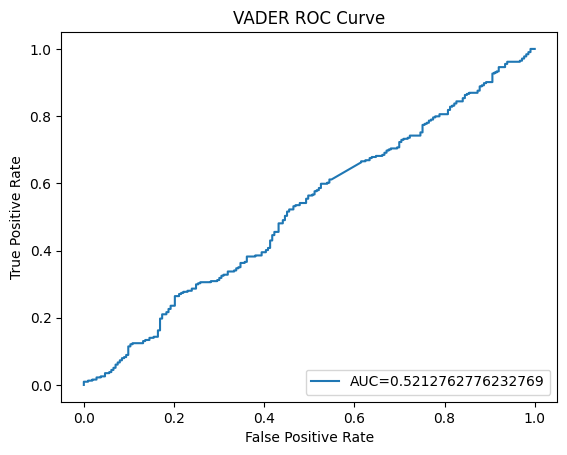

In [133]:
y_pred_proba = log_regression.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

auc= metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve

plt.plot(fpr, tpr,label="AUC="+str(auc))
plt.title('VADER ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)

# CLUSTERING AND LDA

In [53]:
lda = cleaned_df

In [54]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram
import scipy.cluster.hierarchy as sch

def clustering(df, number_words, number_clusters):

    # Get top important words (higest TF-IDF)
    important_words = tfidf_transposed[tfidf_transposed.index.isin(tfidf_sum.head(number_words).word)].index
    important_words_tfidf = tfidf_sum.head(number_words)
    n = len(important_words)

    # Calculate distance between words
    dist = 1 - cosine_similarity(tfidf_transposed[tfidf_transposed.index.isin(tfidf_sum.head(number_words).word)])

    #define the linkage_matrix using ward clustering pre-computed distances
    Z = ward(dist)

    # Number of desired clusters
    T = sch.fcluster(Z, number_clusters, 'maxclust')

    # calculate labels
    labels=list('' for i in range(n))
    for i in range(n):
      labels[i]=str(i)+ ',' + str(T[i])

    # calculate color threshold
    ct=Z[-(number_clusters-1),2]

    # create the colour dictionary
    colors = {}
    for i in range(n):
      colors[important_words[i]] = plt.get_cmap('tab20')(T[i]/number_clusters)


    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(nrows=5, ncols=2, width_ratios=[1, 2], height_ratios=[1,1,100,1,1])
    ax0 = fig.add_subplot(gs[0, 1])

    # Plot dendrogram - Hierarchical Clustering
    ax2 = fig.add_subplot(gs[1:4, 1])
    ax = dendrogram(Z=Z, 
                orientation="right", 
                labels=important_words, 
                color_threshold=ct, 
                above_threshold_color="white",
                ax=ax2,
                leaf_font_size=10
                );
    ax2.set_xlim(0.5, 1.6)

    for leaf, leaf_color in zip(plt.gca().get_yticklabels(), ax["leaves_color_list"]):
      leaf.set_color(leaf_color)

    important_words_tfidf['word'] = pd.Categorical(important_words_tfidf['word'], categories=ax["ivl"], ordered=True)
    important_words_tfidf = important_words_tfidf.sort_values('word')

    

    # Plot bar chart - TF-IDF
    ax1 = fig.add_subplot(gs[:, 0])
    x = important_words_tfidf["word"]
    y = important_words_tfidf["tfidf_sum"]
    ax1.barh(x, y, align='edge', color=[colors[word] for word in x])
    ax1.set_yticks(x)
    ax1.set_yticklabels(x)
    ax1.set_xlim(175,0)
    ax1.tick_params(axis='y', colors='black')

    # Edit the plots
    ax0.spines['right'].set_visible(True)
    ax0.spines['top'].set_visible(False)
    ax0.set_axis_off()
    ax1.spines['top'].set_visible(False)
    ax1.set_axis_off()
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.get_xaxis().set_visible(False)

    ax1.set_title("TF-IDF",loc="right", fontsize=14)
    ax0.set_title("Hierarchical Clustering", fontsize=14)

    #plt.tick_params(axis="y", labelsize=12)
    plt.show() 

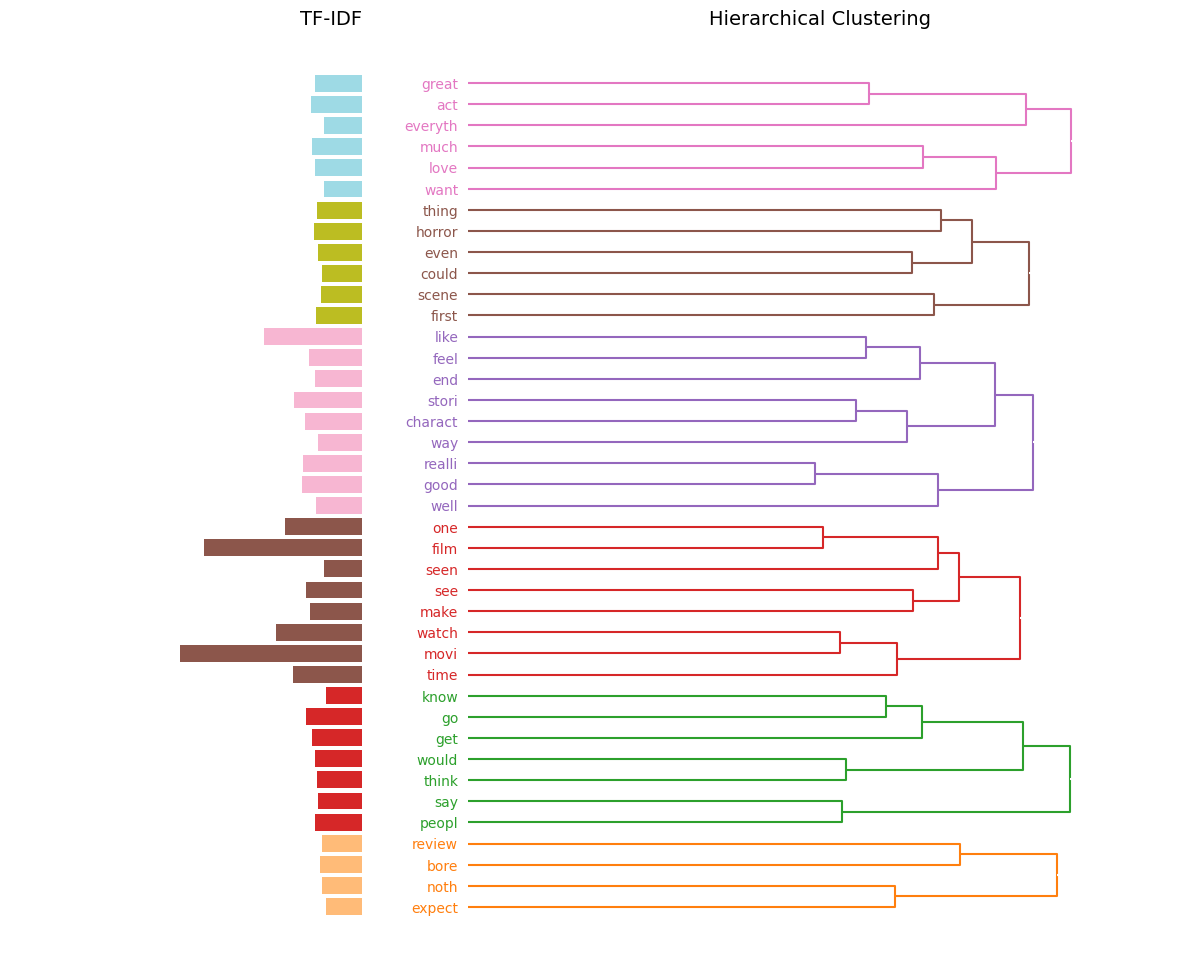

In [55]:
clustering(tf, 40, 6)

Cluster 0:
	act
	movi
	great
	cinematographi
	stori
	gem
	sandler
	good
	film
	score
Cluster 1:
	movi
	famili
	stori
	film
	time
	one
	like
	see
	feel
	go
Cluster 2:
	watch
	movi
	film
	time
	like
	one
	say
	get
	first
	want
Cluster 3:
	film
	like
	one
	stori
	charact
	good
	much
	make
	love
	horror
Cluster 4:
	movi
	like
	realli
	one
	see
	end
	time
	go
	think
	happen


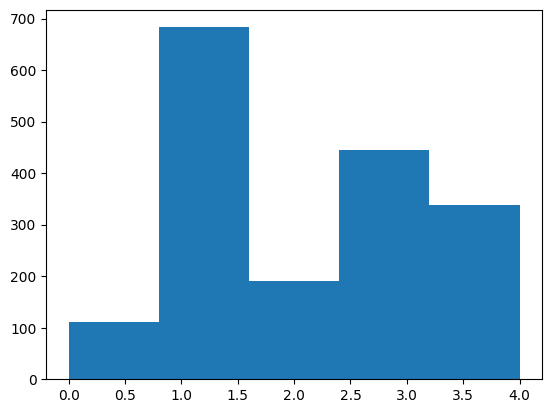

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


X = vectorizer.fit_transform(lda['text_stm'])

# Perform K-means clustering with k=5 clusters
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

# Print the top terms for each cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(k):
    print(f"Cluster {i}:")
    for j in order_centroids[i, :10]:
        print(f"\t{terms[j]}")
    
# Visualize the distribution of documents in each cluster
labels = kmeans.labels_
plt.hist(labels, bins=k)
plt.show()

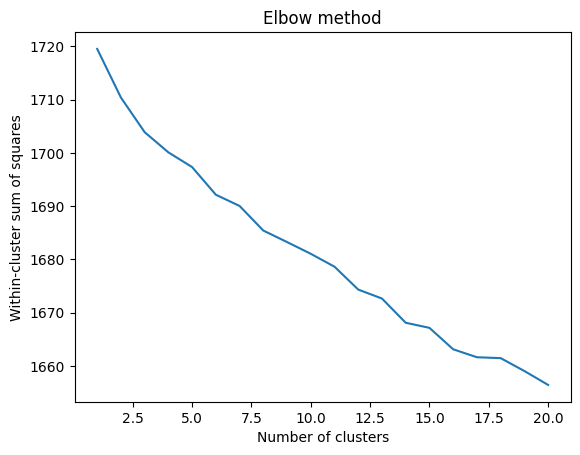

Best number of clusters: 19


In [57]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Compute the within-cluster sum of squares for k=1 to k=20
wcss = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Compute the first differences and the difference ratios
d1 = np.diff(wcss)
d2 = np.diff(d1) / d1[:-1]

# Find the index of the last difference ratio that is less than the 90th percentile of all difference ratios
idx = np.where(d2 < np.percentile(d2, 90))[0][-1]

# Plot the within-cluster sum of squares as a function of k
plt.plot(range(1, 21), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares')
plt.title('Elbow method')
plt.show()

print(f"Best number of clusters: {idx+2}")

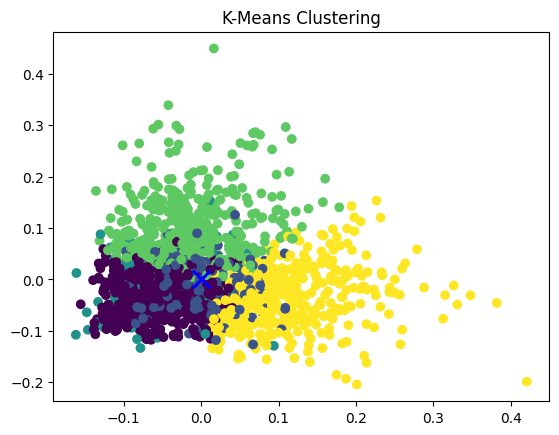

In [58]:

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
k = 5
kmeans = KMeans(n_clusters=k)
kmeans.fit(tf)

labels = kmeans.predict(tf)
centroids = kmeans.cluster_centers_

pca = PCA(n_components=2)
pca_result = pca.fit_transform(tf)

# Plot the data points colored by their cluster labels
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans.labels_)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=150, c='b')
plt.title('K-Means Clustering')
plt.show()

In [59]:
import json
import glob

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy
import spacy
from nltk.corpus import stopwords

# vis
import pyLDAvis
import pyLDAvis.gensim


In [60]:
import ast

preprocessed_texts = lda['text_stm']

preprocessed_texts = preprocessed_texts[~preprocessed_texts.isna()]

# Convert string representation of list to actual list of tokens
data_words = [ast.literal_eval(text) for text in preprocessed_texts]

# Step 2: Create a dictionary
id2word = corpora.Dictionary(data_words)

stop_words = ['film', 'movi', 'watch', 'adam', 'sandler', 'saint', 'maud', 'knight', 'san', 'francisco', 'amanda', 'black', 'man', 'jimmi', 'gawain', 'uncut', 'macbeth', 'green', 'jennif', 'clark', 'lawrenc', 'gem', 'marcel', 'patel']


unwanted_word_ids = [id2word.token2id[word] for word in stop_words if word in id2word.token2id]
id2word.filter_tokens(bad_ids=unwanted_word_ids)


# Step 3: Convert text data to bag-of-words format
corpus = [id2word.doc2bow(text) for text in data_words]

# Step 4: Save corpus and dictionary to disk
corpora.MmCorpus.serialize('corpus.mm', corpus)
id2word.save('dictionary.gensim')

In [67]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=6,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto')

In [68]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds', R=15)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.358757  0.077902       1        1  41.869718
1     -0.129335  0.304772       2        1  25.425154
4      0.124062 -0.314346       3        1  11.593800
0      0.225592  0.201610       4        1   8.199920
2      0.270735 -0.056662       5        1   7.232856
3     -0.132297 -0.213276       6        1   5.678551, topic_info=         Term        Freq       Total Category  logprob  loglift
230    famili  172.000000  172.000000  Default  15.0000  15.0000
2238   horror  212.000000  212.000000  Default  14.0000  14.0000
176   charact  407.000000  407.000000  Default  13.0000  13.0000
253      good  333.000000  333.000000  Default  12.0000  12.0000
29       like  666.000000  666.000000  Default  11.0000  11.0000
...       ...         ...         ...      ...      ...      ...
1358  quickli   18.921637   19.643628   Topic6  -5.3209   2.8310
34      posit   18.734010   19.455314   Topic6  -5.3309   2.8307
2644  student   26.236443   36.738490   Topic6  -4.9941   2.5318
2238   horror   48.356333  212.491119   Topic6  -4.3826   1.3882
225     coupl   25.795292   56.439871   Topic6  -5.0110   2.0855

[153 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
46        1  0.996247    act
248       1  0.991552  actor
901       2  0.115580    age
901       4  0.866849    age
433       4  0.987005  appar
...     ...       ...    ...
114       1  0.045539   year
114       2  0.888018   year
114       5  0.060719   year
431       2  0.995363    yet
2493      3  0.992041  young

[188 rows x 3 columns], R=15, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 5, 1, 3, 4])

In [69]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.5799,"stori, much, could, best, director, lot, scene...","[profoundli, deep, genuin, move, utterli, hila..."
1,1,5,0.4537,"like, one, charact, good, see, go, realli, get...","[troubl, turn, brain, anxieti, worri, mundan, ..."
2,2,5,0.3680,"like, one, charact, good, see, go, realli, get...","[take, drug, first, time, imagin, jacki, chan,..."
3,3,5,0.5154,"like, one, charact, good, see, go, realli, get...","[kind, especi, know, go]"
4,4,5,0.6834,"like, one, charact, good, see, go, realli, get...","[everyth, everywher, even, crazier, trailer, w..."
5,5,5,0.4147,"like, one, charact, good, see, go, realli, get...","[mind, weird, film, truli, film, pointlessli, ..."
6,6,5,0.4259,"like, one, charact, good, see, go, realli, get...","[us, mind, film, agre, one, thing, everyth, ev..."
7,7,5,0.6551,"like, one, charact, good, see, go, realli, get...","[everyth, everywher, sometim, mani, thing, man..."
8,8,1,0.6655,"stori, much, could, best, director, lot, scene...","[point, swept, sensori, overload, much, stuff,..."
9,9,5,0.3991,"like, one, charact, good, see, go, realli, get...","[rare, movi, hit, hard, go, along, ride, everi..."


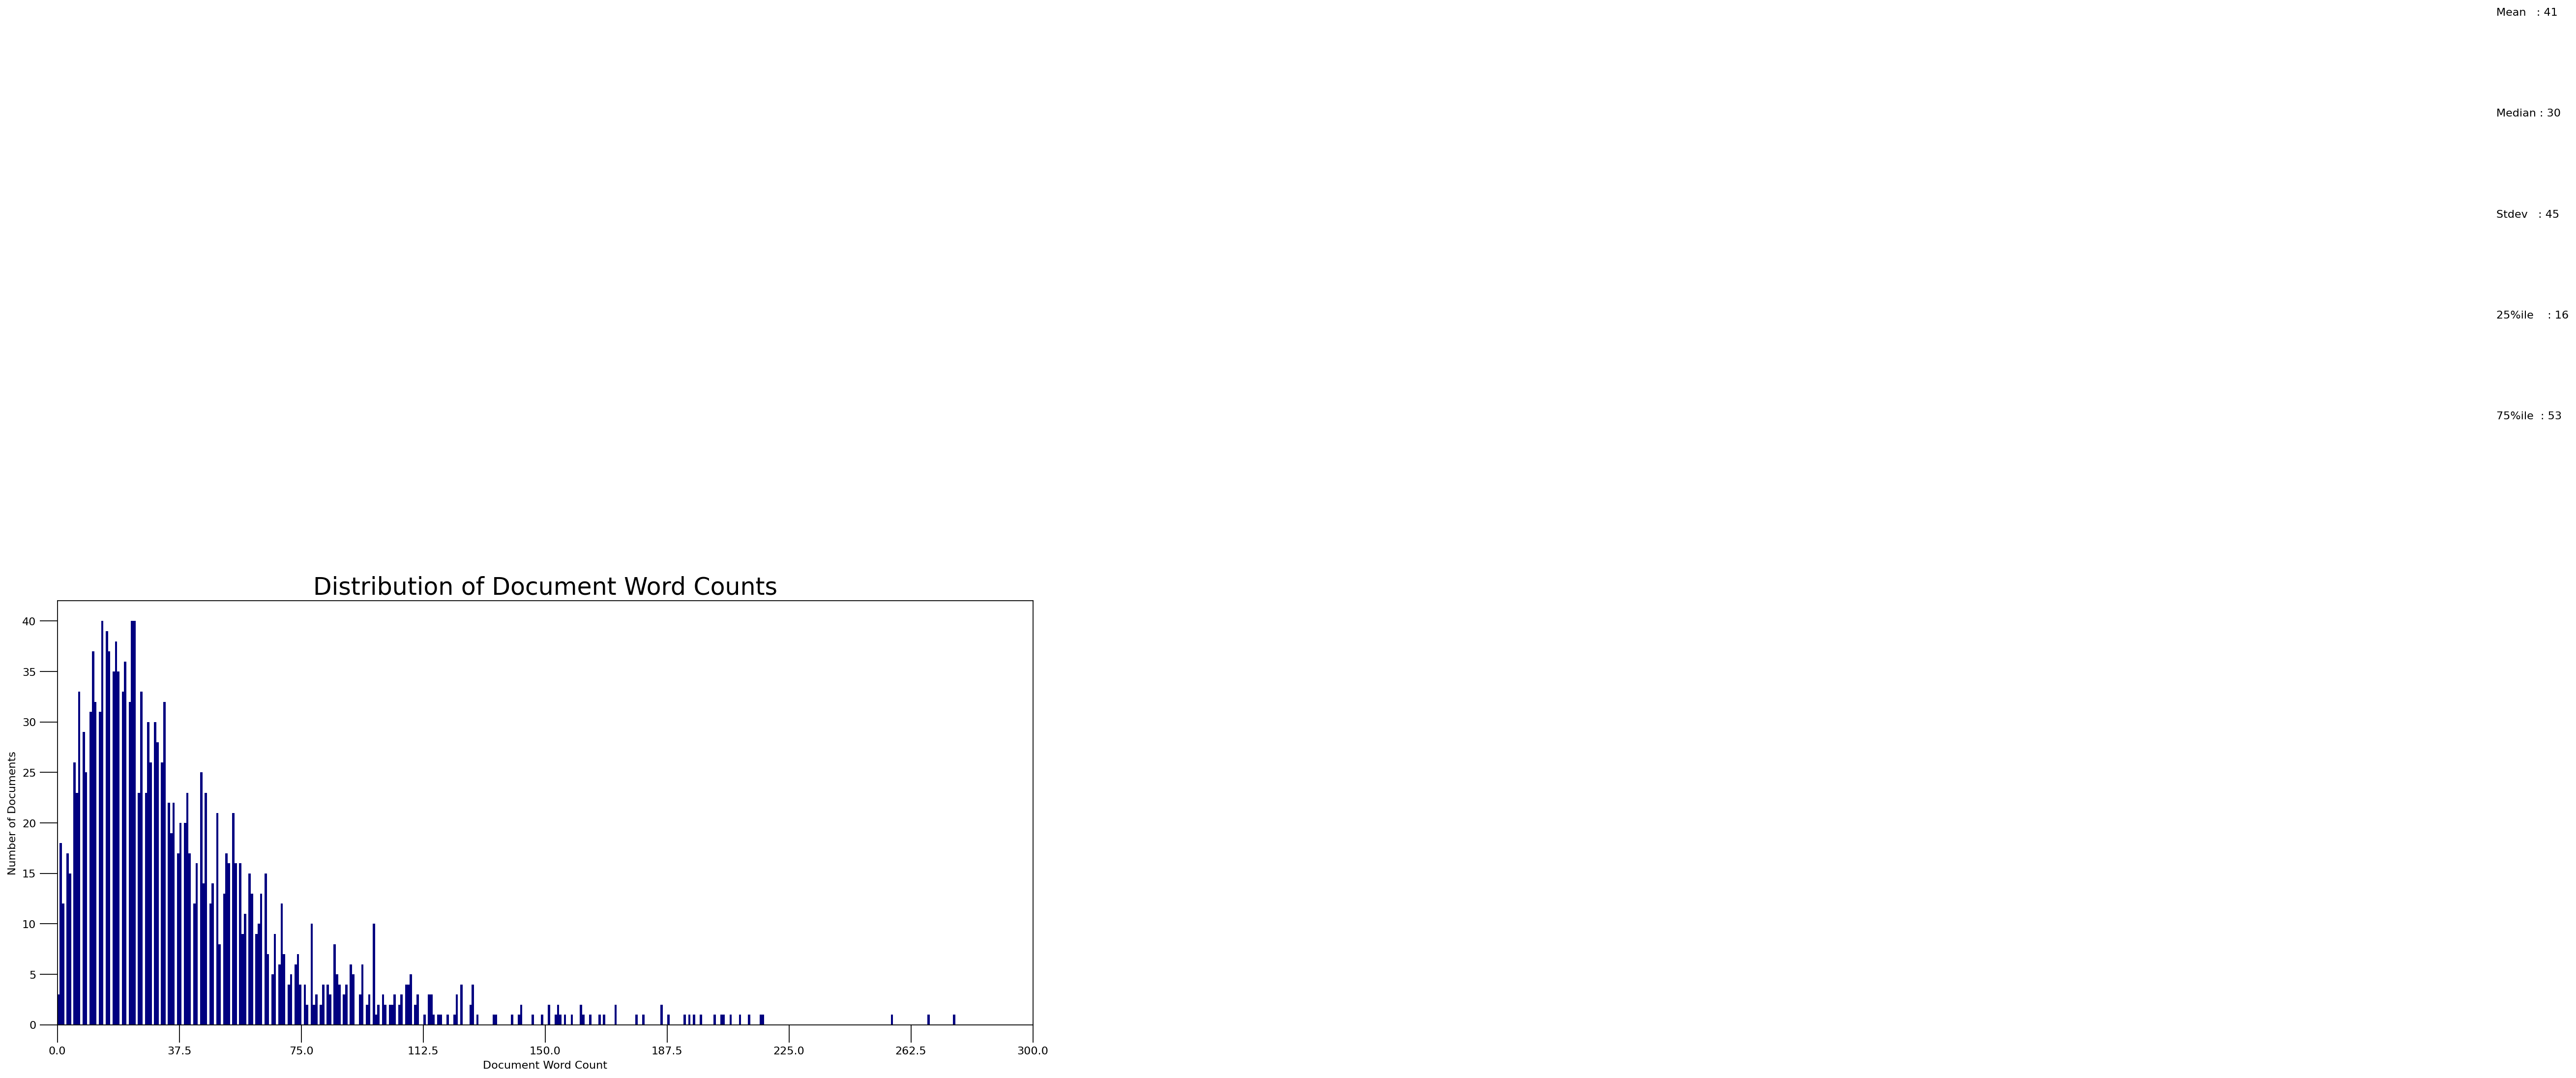

In [70]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "25%ile    : " + str(round(np.quantile(doc_lens, q=0.25))))
plt.text(750,  60, "75%ile  : " + str(round(np.quantile(doc_lens, q=0.75))))

plt.gca().set(xlim=(0, 300), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,300,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

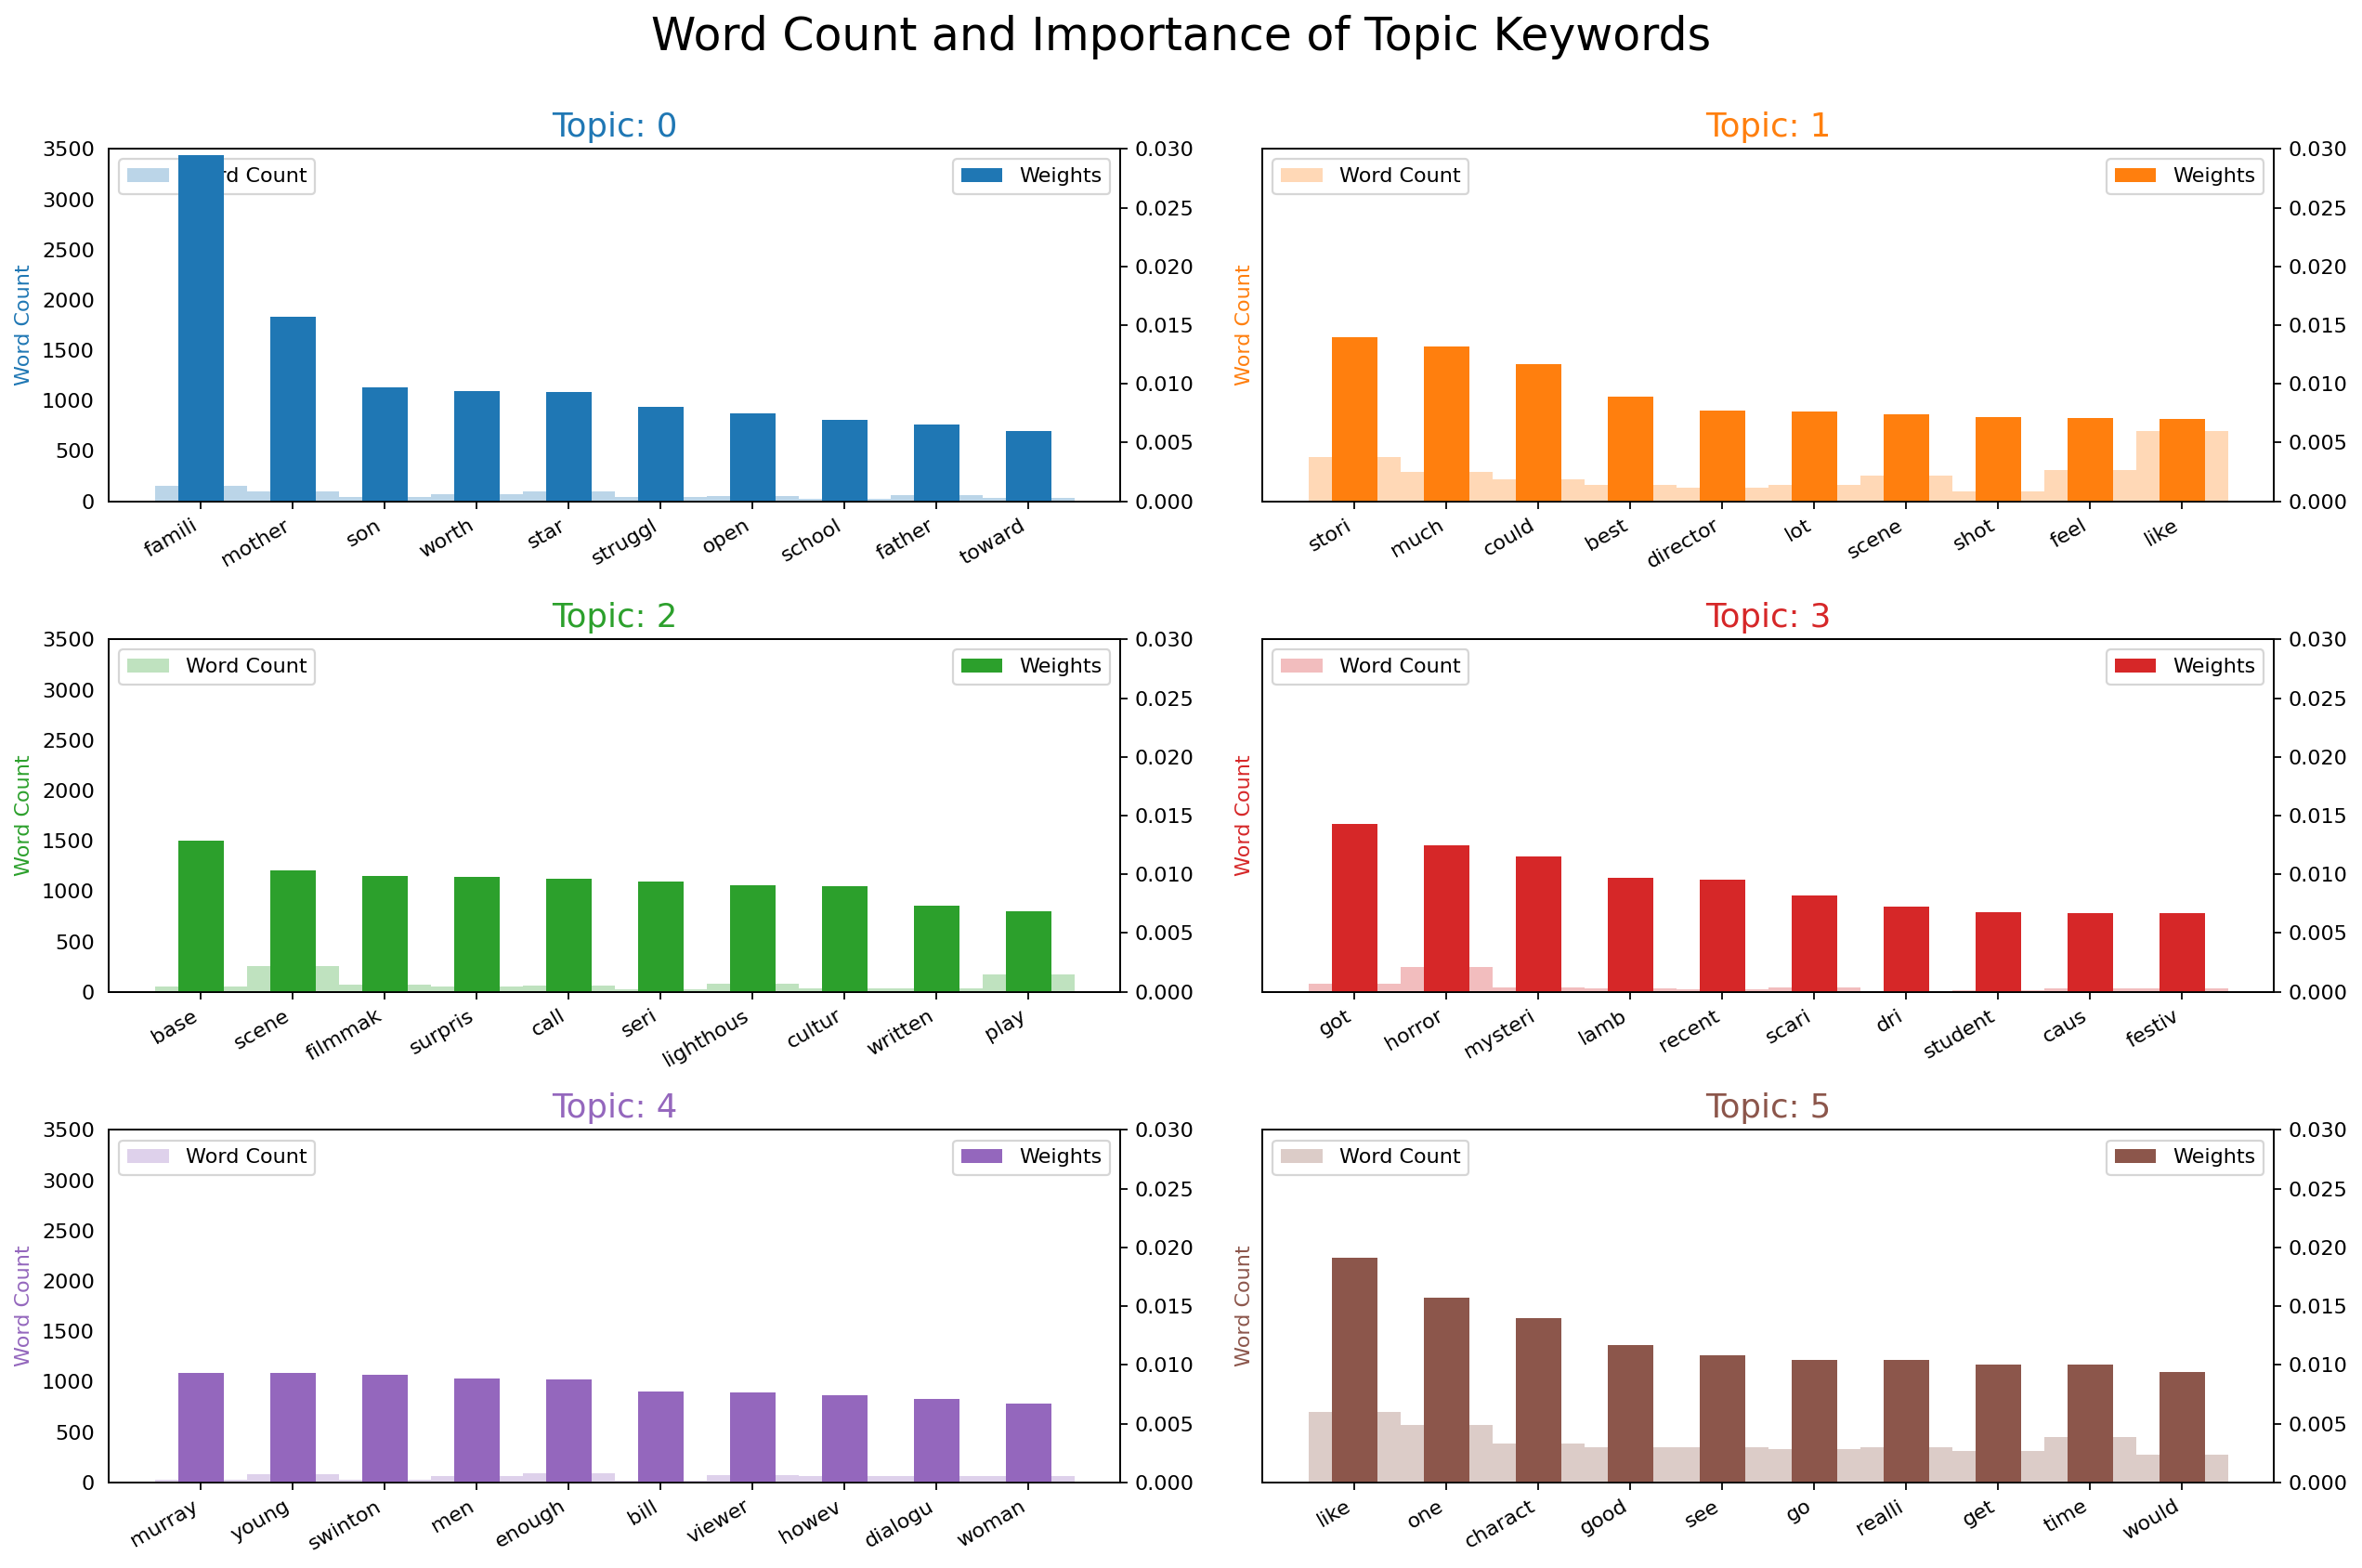

In [71]:
from collections import Counter
import matplotlib.colors as mcolors
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_words for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=1, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()